**MiniProject1: Energy consumption**

Prediction for Ro-Ro vessels from sensor. 
The goal is to predict the energy consumption of the ship. 
Your task is to choose the interval for calculating the energy consumption, which can be given by the rate of the fuel consumption. 
For example, on the daily basis can be calculated by:
EC=(fuelDensityxfuelVolumeFlowRatex3600x24)/1000 (tons/day) 

**Data:**

The data on ship energy consumption were obtained from the Danish ro-ro passenger ship (MS Smyril). 
The MS Smyril has a length of 135 m, a ship width of 22.7 m, a design draft of 5.6 m, and four 3,360 kW main engines. 
The system collects data from the following sensor devices: the Doppler speed log, gyrocompass, Global Positioning System (GPS), main energy pipe flow meter, rudder angles, wind, propeller pitches, inclinometer, and level measurement device. 
The dataset was collected from February to April 2010, with a total of 246 voyages and 1,627,324 data records.

A description of the recorded data is shown in the table below.

- fuelDensity.csv [Fuel density] [kg/l]
- fuelTemp.csv [Fuel temperature] [C]
- fuelVolumeFlowRate.csv [Fuel volume flow rate] [L/s]
- inclinometer-raw.csv [Inclinometer trim angle] [degrees]
- latitude.csv [Latitude]
- longitude.csv [Longitude]
- level1median.csv [Port level measurements] [m] 
- level2median.csv [Starboard level measurements] [m]
- longitudinalWaterSpeed.csv [Speed through water (STW)] [kn]
- portPitch.csv [Port propeller pitch] [-10 - 10 V]
- portRudder.csv [Port rudder angle] [-10 - 10 V]
- speedKmh.csv [Speed over ground (SOG)] [Km/h]
- speedKnots.csv [Speed over ground (SOG)] [Kn]
- starboardPitch.csv [Starboard propeller pitch] [-10 - 10 V]
- starboardRudder.csv [Starboard rudder angle] [-10 - 10 V]
- trackDegreeMagnetic.csv [Track degree magnetic] [degrees]
- trackDegreeTrue.csv [Track degree true] [degrees]
- trueHeading.csv [True] [heading degrees]
- windAngle.csv [Wind] [angle degrees]
- windSpeed.csv [Wind] [speed m/s]


**Task Description:**

The task is to train at least two different machine learning algorithms to predict the energy
consumption of the ship in terms of fuel consumption rate.

You will have to:

1. **Perform data preprocessing**

    - a. What features do you use for your models and why? What is the window interval you choose to predict the target variable?
    - b. How do you prepare the data to be used in your models?
    - c. Feature Engineering

2. **Train the models with at least 85% accuracy.**

3. **Visualize the performance of your models.**

4. **Compare the results of different models, why is there a difference?**

You must submit your Python code in a Jupyter notebook along with a written report. 

**Write a scientific report that includes, but is not limited to, the following points:**
> Introduction (what is the problem you are solving, why do you think it is relevant?)

> Data Processing (What are the data processing decisions you made and how did you implement them?)

> Modeling (What algorithms did you choose and why? How did you run them? How did you
>improve the performance of your models? Were you able to achieve the required accuracy
>in the first round of training?)
 
>Conclusion (What were the "scientific" bottlenecks? How did you overcome them? Which
>algorithm was better? Possible improvements? etc...)

Note: Please understand that the submitted report should include both text and figure
explanations to cover the solution of the task. Only textual or graphical reports will not
receive points. Also, the solution notebook should be completely independent of any local
libraries or local installations in order to be reproducible by the peer reviewer.

***
# <span style="color: #f91974  ; font-weight: bold; font-size: 32px;">0.</span> <span style="color: #974efa  ; font-size: 32px;"><em>INITIALIZATION</em></span> 

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Imports </span> 

In [100]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning models and utilities
from sklearn.feature_selection import VarianceThreshold 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# OS utilities
import os

# Collab
#from google.colab import files



<span style="color:rgb(137, 187, 249); font-size: 20px;"> Settings and Constants </span> 

In [101]:
# set pandas options to show dataframe columns on single lines
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wide enough for no wrapping
pd.set_option('display.max_colwidth', None)  # Avoid truncating long text

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Define ANSI escape codes for text
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
ORANGE = "\033[38;5;208m"
L_ORANGE = "\033[38;5;214m"
YELLOW_BG = '\033[43m'
GREY_BG = '\033[100m'
BLUE_BG = "\033[44m" 
ORANGE_BG = "\033[48;2;220;140;0m"
DARK_GREY_BG = "\033[48;5;239m" 
RESET = "\033[0m"

***
# <span style="color: #f91974  ; font-weight: bold; font-size: 32px;">1.</span> <span style="color: #974efa  ; font-size: 32px;"><em>PREPROCESSING</em></span> 

- <span style="color: #cddeb3 ;"> How do you prepare the data to be used in your models? </span> 
- <span style="color: #cddeb3 ;"> What features do you use for your models and why? What is the window interval you choose to predict the target variable? </span>
- <span style="color: #cddeb3 ;">  Feature Engineering </span>


## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">1. a)</span> <span style="color: #b889f9; font-size: 24px;"> Import Data and Create Dataframe, Summary Statistics</span> 

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Import Data </span> 

We first create a function to import all the csv data.
This function import_csv_to_df() handles the import and initial processing of ship sensor data from multiple CSV files. 

For each sensor (fuel density, temperature, speed, etc.), there is a separate CSV file in a 'data' folder. The function:

1. Maintains a list of all CSV files to be imported
2. Contains a mapping dictionary that defines the meaning and units for each measurement (e.g., fuel density in kg/l, speed in knots)
3. Creates unique column names by prefixing each measurement with its source file name to avoid conflicts
4. Reads each CSV file without headers and applies the appropriate column names
5. Stores each DataFrame in a dictionary where the keys are the file names
6. Prints information about each loaded file including column names and the first few rows
7. Returns a dictionary containing all the individual DataFrames

Getting this data will provide the foundation for further data preprocessing, as it brings all the sensor data into Python in an organized way where each measurement can be uniquely identified.

In [102]:
def import_csv_to_df():
   # 1. Maintains a list of all CSV files to be imported
   data_folder = "data/"
   csv_files = [
       "fuelDensity.csv",
       "fuelTemp.csv",
       "fuelVolumeFlowRate.csv",
       "inclinometer-raw.csv",
       "latitude.csv",
       "longitude.csv",
       "level1median.csv",
       "level2median.csv",
       "longitudinalWaterSpeed.csv",
       "portPitch.csv",
       "portRudder.csv",
       "speedKmh.csv",
       "speedKnots.csv",
       "starboardPitch.csv",
       "starboardRudder.csv",
       "trackDegreeMagnetic.csv",
       "trackDegreeTrue.csv",
       "trueHeading.csv",
       "windAngle.csv",
       "windSpeed.csv"
   ]
   
   # 2. Contains a mapping dictionary that defines the meaning and units for each measurement
   column_mapping = {
       "fuelDensity.csv":            ["Fuel density", "kg/l"],
       "fuelTemp.csv":               ["Fuel temperature", "C"],
       "fuelVolumeFlowRate.csv":     ["Fuel volume flow rate", "L/s"],
       "inclinometer-raw.csv":       ["Inclinometer trim angle", "degrees"],
       "latitude.csv":               ["Latitude", "N/A"],
       "longitude.csv":              ["Longitude", "N/A"],
       "level1median.csv":           ["Port level measurements", "m"],
       "level2median.csv":           ["Starboard level measurements", "m"],
       "longitudinalWaterSpeed.csv": ["Speed through water (STW)", "kn"],
       "portPitch.csv":              ["Port propeller pitch", "-10 - 10 V"],
       "portRudder.csv":             ["Port rudder angle", "-10 - 10 V"],
       "speedKmh.csv":               ["Speed over ground (SOG)", "Km/h"],
       "speedKnots.csv":             ["Speed over ground (SOG)", "Kn"],
       "starboardPitch.csv":         ["Starboard propeller pitch", "-10 - 10 V"],
       "starboardRudder.csv":        ["Starboard rudder angle", "-10 - 10 V"],
       "trackDegreeMagnetic.csv":    ["Track degree magnetic", "degrees"],
       "trackDegreeTrue.csv":        ["Track degree true", "degrees"],
       "trueHeading.csv":            ["True", "heading degrees"],
       "windAngle.csv":              ["Wind", "angle degrees"],
       "windSpeed.csv":              ["Wind", "speed m/s"]
   }
   
   # 3. Creates unique column names by prefixing each measurement with its source file name
   unique_mapping = {}
   for file, names in column_mapping.items():
       file_key = file.replace(".csv", "")
       unique_names = [f"{file_key}_{name}" for name in names]
       unique_mapping[file] = unique_names
   
   # 4. Reads each CSV file without headers and applies the appropriate column names
   # 5. Stores each DataFrame in a dictionary where the keys are the file names
   data = {}
 
   for file in csv_files:
       file_path = os.path.join(data_folder, file)
       try:
           df = pd.read_csv(file_path, header=None)
           
           if file in unique_mapping:
               desired_cols = unique_mapping[file]
               num_actual_cols = df.shape[1]
               if num_actual_cols == len(desired_cols):
                   df.columns = desired_cols
               else:
                   df.columns = desired_cols[:num_actual_cols]
           else:
               print(f"{DARK_GREY_BG}No column mapping provided for {file}. Using default names.{RESET}")
           
           data[file] = df
           # 6. Prints information about each loaded file including column names and first few rows
           print(f"{DARK_GREY_BG}Loaded {file} with unique columns: {df.columns.tolist()}{RESET}")
           print(df.head(), "\n")
           
       except Exception as e:
           print(f"Error loading {file}: {e}")
   
   # 7. Returns a dictionary containing all the individual DataFrames
   return data


#############################################################
dfs_dict = import_csv_to_df()                                                           #  <------------ dfs_dict
                                                                                        #      |
#print(dfs_dict["fuelDensity.csv"].info())                                              #  <---| fuelDensity.csv 

Loaded fuelDensity.csv with unique columns: ['fuelDensity_Fuel density', 'fuelDensity_kg/l']
   fuelDensity_Fuel density  fuelDensity_kg/l
0        634019142119225390          0.947109
1        634019142129597610          0.947110
2        634019142139821660          0.947114
3        634019142150036040          0.947104
4        634019212935606850          0.938305 

Loaded fuelTemp.csv with unique columns: ['fuelTemp_Fuel temperature', 'fuelTemp_C']
   fuelTemp_Fuel temperature  fuelTemp_C
0         634019142119225390    62.20651
1         634019142129597610    62.20406
2         634019142139821660    62.19989
3         634019142150036040    62.20412
4         634019212935606850    86.89216 

Loaded fuelVolumeFlowRate.csv with unique columns: ['fuelVolumeFlowRate_Fuel volume flow rate', 'fuelVolumeFlowRate_L/s']
   fuelVolumeFlowRate_Fuel volume flow rate  fuelVolumeFlowRate_L/s
0                        634019142119225390                0.000000
1                        6340191421295

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Create Combined DataFrame </span> 

Next we take the individual sensor DataFrames from ship readings and combine them into a single unified DataFrame. 

The code has following stages:

1. Creates an empty list to temporarily store modified versions of each sensor's DataFrame

2. For each sensor DataFrame in our dictionary:

- Extracts a clean sensor name from the filename (removing '.csv')
- Uses the first column (containing timestamps) as the index
- Renames the measurement column to match the sensor name

3. Combines all modified sensor DataFrames into one by:

- Using pandas concat to join them side-by-side (axis=1)
- Performing an outer join on the index (keeping all timestamps)
- Sorting by the index (timestamps) to maintain chronological order

4. Prints information about the final combined DataFrame:

- Basic DataFrame information
- First few rows of data
- First 100 rows for detailed inspection

This creates a wide-format DataFrame where:

- Each row represents a specific timestamp
- Each column represents measurements from a different sensor
- Missing values (when a sensor didn't record at a particular timestamp) are filled with NaN

In [ ]:
def merge_dataframes(data_dict):
   """ Code to combine individual sensor DataFrames into a single unified DataFrame """
   
   # 1. Creates an empty list to temporarily store modified versions of each sensor's DataFrame
   dfs_for_merge = []

   # 2. For each sensor DataFrame in our dictionary:
   for filename, df in data_dict.items():
       # Extracts a clean sensor name from the filename (removing '.csv')
       sensor_key = filename.replace(".csv", "")
       
       # Uses the first column (containing timestamps) as the index
       df_indexed = df.set_index(df.columns[0])
       
       # Renames the measurement column to match the sensor name
       df_indexed = df_indexed.rename(columns={df_indexed.columns[0]: sensor_key})
       
       # Add modified DataFrame to our list
       dfs_for_merge.append(df_indexed)

   # 3. Combines all modified sensor DataFrames into one by:
   # - Using pandas concat to join them side-by-side (axis=1)
   # - Performing an outer join on the index (keeping all timestamps)
   # - Sorting by the index (timestamps) to maintain chronological order
   df_combined = pd.concat(dfs_for_merge, axis=1, join='outer')
   df_combined.sort_index(inplace=True)

   # 4. Prints information about the final combined DataFrame:
   print(f"{DARK_GREY_BG}Combined DataFrame Info {RESET}")
   print(df_combined.info())
   print(f"\n{DARK_GREY_BG}First few rows:{RESET}")
   print(df_combined.head())

   return df_combined

#############################################################
# Create our combined DataFrame
df_combined = merge_dataframes(dfs_dict)                                                        #  <------------ combined_df

Combined DataFrame Info 
<class 'pandas.core.frame.DataFrame'>
Index: 19045464 entries, 634018095128184147 to 634067079164694510
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   fuelDensity             float64
 1   fuelTemp                float64
 2   fuelVolumeFlowRate      float64
 3   inclinometer-raw        float64
 4   latitude                object 
 5   longitude               object 
 6   level1median            float64
 7   level2median            float64
 8   longitudinalWaterSpeed  float64
 9   portPitch               float64
 10  portRudder              float64
 11  speedKmh                float64
 12  speedKnots              float64
 13  starboardPitch          float64
 14  starboardRudder         float64
 15  trackDegreeMagnetic     float64
 16  trackDegreeTrue         float64
 17  trueHeading             float64
 18  windAngle               float64
 19  windSpeed               float64
dtypes: float64(18), obj

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">1. b)</span> <span style="color: #b889f9; font-size: 24px;"> Initial Data Exploration </span> 

Now that we have a single DataFrame that contains all the sensor information, we perform some intial data exploration get an idea of the data. 
We will structure the exploration to specifically help with our ship energy consumption prediction task. 
In line with this, our intial exploration focuses on:

1. Our target variables (fuel-related):

- When do we have both fuelDensity and fuelVolumeFlowRate measurements
- Their distributions and patterns
- Any missing data patterns

2. Data quality (entire dataset related):

- Outliers
- Missing value patterns
- Any inconsistent or suspicious values

In [104]:
def target_columns_exploration(df):
    """ Explores fuel-related measurements which will form our target variable """
    
    # Check availability of fuel measurements
    print(f"{DARK_GREY_BG}Fuel Measurements Availability:{RESET}")
    fuel_cols = ['fuelDensity', 'fuelVolumeFlowRate']
    total_rows = len(df)
    
    for col in fuel_cols:
        non_null = df[col].count()
        print(f"\n{col}:")
        print(f"Available measurements: {non_null:,}")
        print(f"Missing values: {total_rows - non_null:,}")
        print(f"Coverage: {(non_null/total_rows)*100:.2f}%")
    
    # Check where we have both measurements
    both_available = df[fuel_cols].dropna().index
    print(f"\nRows with both fuel measurements: {len(both_available):,}")
    print(f"Coverage of complete fuel data: {(len(both_available)/total_rows)*100:.2f}%")
    
    # Basic statistics for non-null values
    print(f"\n{DARK_GREY_BG}Basic statistics for fuel measurements:{RESET}")
    print(df[fuel_cols].describe())
    
    # Time range for fuel measurements
    print(f"\n{DARK_GREY_BG}Time range of fuel measurements:{RESET}")
    fuel_data = df[fuel_cols].dropna()
    print(f"Start: {fuel_data.index.min()}")
    print(f"End: {fuel_data.index.max()}")

#############################################################
target_columns_exploration(df_combined)

Fuel Measurements Availability:

fuelDensity:
Available measurements: 1,627,324
Missing values: 17,418,140
Coverage: 8.54%

fuelVolumeFlowRate:
Available measurements: 1,627,324
Missing values: 17,418,140
Coverage: 8.54%

Rows with both fuel measurements: 1,627,324
Coverage of complete fuel data: 8.54%

Basic statistics for fuel measurements:
        fuelDensity  fuelVolumeFlowRate
count  1.627324e+06        1.627324e+06
mean   9.267002e-01        5.886810e-01
std    2.476055e-03        1.191916e-01
min    9.213957e-01        0.000000e+00
25%    9.251580e-01        5.875236e-01
50%    9.258808e-01        6.261127e-01
75%    9.272907e-01        6.530258e-01
max    9.850411e-01        9.468417e-01

Time range of fuel measurements:
Start: 634019142119225390
End: 634067079162304710


Target Variables (Fuel Measurements) Findings:

- We have complete fuel measurement data (both density and flow rate) for only 8.54% of all timestamps, representing 1.63M measurements
- Fuel density is remarkably consistent, varying between 0.921-0.985 kg/l with very low standard deviation (0.002)
- Fuel volume flow rate ranges from 0 to 0.947 L/s, with a mean of 0.589 L/s
- There's a perfect overlap in missing data between fuel density and flow rate measurements, suggesting they're likely measured by the same system or during the same operations

In [105]:
def combined_dataframe_exploration(df):
    """ Provides a simple, broad exploration of the entire combined DataFrame """

    # 1. Shape and column names
    print(f"{DARK_GREY_BG}SHAPE AND COLUMNS {RESET}")
    print(f"DataFrame shape: {df.shape}")
    print("Columns:", list(df.columns))
    
    # 2. Data info
    print(f"\n{DARK_GREY_BG}DATAFRAME INFO {RESET}")
    print(df.info())
    
    # 3. Missing Values
    print(f"\n{DARK_GREY_BG}MISSING VALUES PER COLUMN {RESET}")
    missing_counts = df.isnull().sum().sort_values(ascending=False)
    for col in missing_counts.index:
        pct = 100 * missing_counts[col] / len(df)
        print(f"{col}: {missing_counts[col]} missing ({pct:.2f}%)")
        
    # 4. Basic Statistics for Numeric Columns
    #    (Non-numeric columns are automatically excluded)
    print(f"\n{DARK_GREY_BG}BASIC STATISTICS (NUMERIC COLUMNS) {RESET}")
    display(df.describe())
    

#############################################################
combined_dataframe_exploration(df_combined)

SHAPE AND COLUMNS 
DataFrame shape: (19045464, 20)
Columns: ['fuelDensity', 'fuelTemp', 'fuelVolumeFlowRate', 'inclinometer-raw', 'latitude', 'longitude', 'level1median', 'level2median', 'longitudinalWaterSpeed', 'portPitch', 'portRudder', 'speedKmh', 'speedKnots', 'starboardPitch', 'starboardRudder', 'trackDegreeMagnetic', 'trackDegreeTrue', 'trueHeading', 'windAngle', 'windSpeed']

DATAFRAME INFO 
<class 'pandas.core.frame.DataFrame'>
Index: 19045464 entries, 634018095128184147 to 634067079164694510
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   fuelDensity             float64
 1   fuelTemp                float64
 2   fuelVolumeFlowRate      float64
 3   inclinometer-raw        float64
 4   latitude                object 
 5   longitude               object 
 6   level1median            float64
 7   level2median            float64
 8   longitudinalWaterSpeed  float64
 9   portPitch               float64
 10  portRudder 

,fuelDensity,fuelTemp,fuelVolumeFlowRate,inclinometer-raw,level1median,level2median,longitudinalWaterSpeed,portPitch,portRudder,speedKmh,speedKnots,starboardPitch,starboardRudder,trackDegreeMagnetic,trackDegreeTrue,trueHeading,windAngle,windSpeed
count,1.627324e+06,1.627324e+06,1.627324e+06,3.559677e+06,3.979774e+06,3.840794e+06,548292.000000,1.726076e+06,1.726076e+06,1.766906e+06,1.766908e+06,1.726076e+06,1.726076e+06,1.766474e+06,1.766479e+06,1.439539e+06,863755.000000,863755.000000
mean,9.267002e-01,9.753591e+01,5.886810e-01,3.572583e+02,1.670620e+01,1.471384e+01,17.540864,7.544686e+00,-3.820208e-01,3.318033e+01,1.791553e+01,7.359474e+00,1.293074e-01,1.750509e+02,1.743925e+02,1.710521e+02,165.280740,13.977070
std,2.476055e-03,1.873775e+00,1.191916e-01,3.152965e-01,6.253208e-01,5.763419e-01,5.297758,2.331686e+00,1.815706e+00,9.366201e+00,5.057081e+00,2.717654e+00,1.773242e+00,1.136347e+02,1.139529e+02,1.181323e+02,145.043311,7.235937
min,9.213957e-01,1.436032e+01,0.000000e+00,9.000000e-02,3.016037e+00,3.183841e+00,-6.800000,-7.372000e+00,-8.255000e+00,0.000000e+00,0.000000e+00,-8.403000e+00,-8.274000e+00,0.000000e+00,0.000000e+00,4.000000e-02,0.000000,0.000000
25%,9.251580e-01,9.683320e+01,5.875236e-01,3.572200e+02,1.635726e+01,1.439313e+01,18.500000,8.081000e+00,-2.020000e-01,3.390000e+01,1.830000e+01,7.999000e+00,-1.790000e-01,5.080000e+01,8.480000e+01,4.743000e+01,12.000000,8.200000
50%,9.258808e-01,9.785078e+01,6.261127e-01,3.572500e+02,1.665746e+01,1.467931e+01,19.400000,8.316000e+00,-3.800000e-02,3.610000e+01,1.950000e+01,8.258000e+00,-3.700000e-02,1.886000e+02,1.851000e+02,1.855700e+02,133.000000,13.500000
75%,9.272907e-01,9.856158e+01,6.530258e-01,3.572800e+02,1.697293e+01,1.500381e+01,19.900000,8.487000e+00,1.010000e-01,3.780000e+01,2.040000e+01,8.413000e+00,9.200000e-02,2.449000e+02,2.806000e+02,2.395800e+02,315.000000,19.200000
max,9.850411e-01,1.041328e+02,9.468417e-01,3.599200e+02,3.251493e+01,3.421978e+02,22.000000,9.169000e+00,8.299000e+00,4.670000e+01,2.520000e+01,9.027000e+00,8.638000e+00,3.599000e+02,3.600000e+02,3.599900e+02,359.000000,45.300000


Combined DataFrame Findings:

- The dataset is extensive with 19M timestamps and 20 different sensor measurements
- Data quality is a significant challenge - all variables have high missing rates ranging from 79% to 97%
- Most sensors (18 out of 20) provide numeric data, with only latitude and longitude stored as objects
- Water speed measurements are the most sparse (97.12% missing), while level measurements (level1median, level2median) are the most complete (around 79% missing)
- The consistent pattern of missing data across multiple sensors (many around 90-91% missing) suggests systematic data collection patterns, possibly related to specific operational states or measurement cycles

Let's investigate and analayze the missing values a bit closer, starting by visualizing the missing rates.

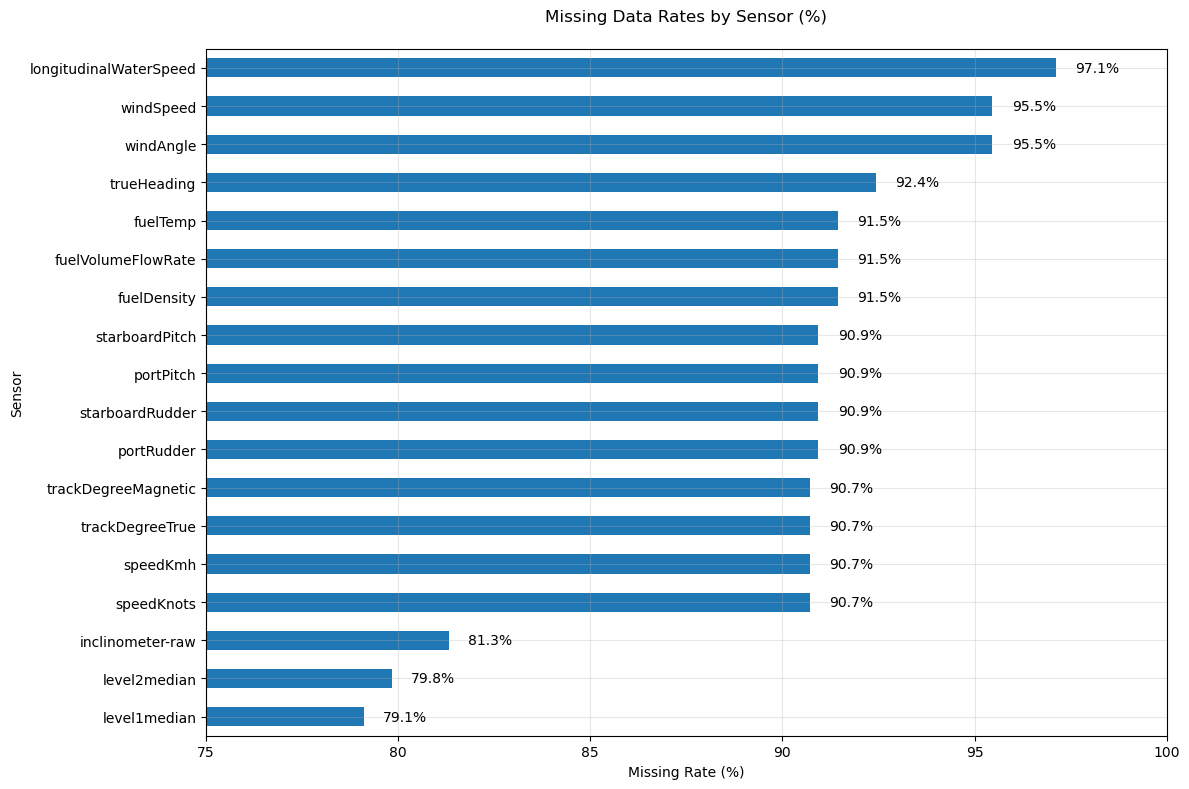

In [ ]:
def plot_missing_rates(df):
    """ Creates a horizontal bar plot of missing rates for numeric columns """

    numeric_cols = df.select_dtypes(include=['float64']).columns
    missing_rates = (df[numeric_cols].isnull().sum() / len(df) * 100).sort_values(ascending=True)
    
    plt.figure(figsize=(12, 8))
    missing_rates.plot(kind='barh')
    
    plt.title('Missing Data Rates by Sensor (%)', pad=20)
    plt.xlabel('Missing Rate (%)')
    plt.ylabel('Sensor')
    
    for i, v in enumerate(missing_rates):
        plt.text(v + 0.5, i, f'{v:.1f}%', va='center')
    
    plt.xlim(75, 100)  
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#############################################################
plot_missing_rates(df_combined)

Looking at the data, we notice a significant disparity in missing values across different sensor measurements.

> At one end, we have sensors with ***extremely high missing rates*** (95-97%): longitudinal water speed (97.1%), wind speed (95.5%), and wind angle (95.5%). 

These measurements, despite their sparsity, are physically significant for energy consumption prediction as they directly impact vessel performance and resistance through water. The consistent missing rate pattern among wind measurements suggests these gaps might be due to a specific sensor system or measurement protocol.

> At the other end of the spectrum, we find sensors with ***relatively lower missing rates*** (around 80%): port level measurements (79.1%), starboard level measurements (79.8%), and inclinometer trim angle (81.3%). 

These measurements, while more complete, are primarily related to the ship's physical orientation and balance in water. Their different missing pattern, compared to other sensors, suggests they might operate on a separate measurement system. Crucially, these more frequently measured variables likely represent timestamps where our other, more relevant sensors weren't active - meaning that keeping these measurements might actually fragment our dataset, as we'd be including timestamps where we have level/inclinometer readings but miss critical propulsion and environmental data. In other words, the timestamps where these measurements exist might not align well with the timestamps of our more relevant but sparser measurements.

Given this analysis, it would be more strategic to ***maintain the high-missing but physically significant variables*** (wind and water speed) despite their sparsity, as they are crucial for energy consumption prediction. 

Instead, we might consider ***dropping the more complete but less directly relevant measurements*** (level measurements and inclinometer data). This approach would help focus our dataset on the most relevant features for energy consumption prediction while potentially providing a ***more cohesive set of measurements that operate on similar temporal patterns***. By removing the columns with more complete data but different measurement patterns, we might actually end up with more usable complete rows in our final dataset, as we'd be focusing on timestamps where our critical measurements were actually being recorded.

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">1. c)</span> <span style="color: #b889f9; font-size: 24px;"> Ensure Data Structure Cohesiveness and Engineer Valid Date Range </span> 

Having identified the columns that might fragment our dataset due to their different measurement patterns, we now need to take two important steps to ensure data structure consistency. 

>First, we'll implement our findings from the previous section by ***dropping the columns with different measurement frequencies*** (level measurements and inclinometer data), which should help create a more cohesive dataset. We should also drop other columns that are not relevant for determining our label data (fuel consumption).

>Second, we need to determine an appropriate ***time range for aggregating our measurements***. Since our data points are recorded at various timestamps, finding the right aggregation interval will be crucial for creating meaningful rows where we have valid measurements for our target variables (fuel density and volume flow rate). This temporal aggregation will help us align measurements from different sensors and create a more structured dataset suitable for our energy consumption prediction task.

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Drop Columns </span> 

In addition to dropping the columns that may cause distortion in measured values, the following analysis led to more columns that might be dropped.

Based on the task description, we need to predict energy consumption which depends primarily on fuel consumption. 


**Label Columns:**
- *fuelDensity* - directly used in energy consumption calculation
- *fuelVolumeFlowRate* - directly used in energy consumption calculation


**Essential Columns:**
- *speedKnots* - speed over ground affects energy consumption
- *windSpeed and windAngle* - wind resistance affects fuel consumption
- *longitudinalWaterSpeed* - speed through water is important for energy consumption
- *portPitch and starboardPitch* - propeller settings affect energy usage
- *portRudder and starboardRudder* - rudder positions affect resistance
- *inclinometer-raw* - trim angle affects ship resistance


**Non-Essential Columns:**
- *fuelTemp* - less direct impact on energy consumption
- *latitude and longitude* - not directly relevant for energy consumption prediction
- *level1median and level2median* - level measurements less relevant for energy prediction
- *speedKmh* - redundant since we have speedKnots
- *trackDegreeMagnetic and trackDegreeTrue* - course information less relevant
- *trueHeading* - heading information less important for energy consumption

In [ ]:
def drop_columns(original_df):
    """ Removes non-essential columns and any rows that contain only NaN values after removal """
    
    # Create a copy of the original DataFrame
    cohesive_df = original_df.copy()
    
    # Define columns to drop based on both measurement patterns and relevance
    columns_to_drop = [
        # Different measurement pattern columns
        'level1median',         # Port level measurements
        'level2median',         # Starboard level measurements
        'inclinometer-raw',     # Trim angle
        
        # Non-essential columns for energy consumption
        'fuelTemp',            # Less direct impact
        'latitude',            # Location not directly relevant
        'longitude',           # Location not directly relevant
        'speedKmh',           # Redundant with speedKnots
        'trackDegreeMagnetic', # Course information less relevant
        'trackDegreeTrue',     # Course information less relevant
        'trueHeading'          # Heading information less relevant
    ]
    
    # Drop specified columns
    cohesive_df = cohesive_df.drop(columns=columns_to_drop)
    
    # Count rows before removing all-NaN rows
    rows_before = len(cohesive_df)
    
    # Remove rows where all values are NaN
    cohesive_df = cohesive_df.dropna(how='all')
    
    # Count removed rows
    rows_removed = rows_before - len(cohesive_df)
    
    # Print information about the changes
    print(f"\n{DARK_GREY_BG}DataFrame Info After Creating Cohesive Dataset {RESET}")
    print(f"Original shape: {original_df.shape}")
    print(f"Shape after dropping columns: {cohesive_df.shape}")
    print(f"Number of all-NaN rows removed: {rows_removed:,}")
    print(f"Percentage of rows removed: {(rows_removed/rows_before)*100:.2f}%")
    
    # Calculate and display new missing rates
    missing_rates = (cohesive_df.isnull().sum() / len(cohesive_df) * 100).sort_values(ascending=False)
    print(f"\n{DARK_GREY_BG} Missing Rates in Cohesive Dataset {RESET}")
    print(missing_rates)
    
    return cohesive_df

#############################################################
df_cohesive_v1 = drop_columns(df_combined)                                                          #  <------------ df_cohesive_v1


DataFrame Info After Creating Cohesive Dataset 
Original shape: (19045464, 20)
Shape after dropping columns: (6532355, 10)
Number of all-NaN rows removed: 12,513,109
Percentage of rows removed: 65.70%

 Missing Rates in Cohesive Dataset 
longitudinalWaterSpeed    91.606519
windAngle                 86.777280
windSpeed                 86.777280
fuelDensity               75.088249
fuelVolumeFlowRate        75.088249
portPitch                 73.576513
portRudder                73.576513
starboardPitch            73.576513
starboardRudder           73.576513
speedKnots                72.951439
dtype: float64


By removing both non-essential columns and all-NaN rows (which were about 65.78% of our dataset, after dropping columns), we've achieved a more focused and cohesive dataset where:

- The missing rates now range from around 72% to 91% across our essential variables
- Our fuel-related measurements (fuelDensity, fuelVolumeFlowRate) both have about 75% missing values, showing good alignment
- Most operational parameters (pitch, rudder measurements) are consistently around 73.5% missing
- Speed measurements (speedKnots) have the lowest missing rate at about 72.5%
- Water speed and wind measurements remain the most sparse with about 91% (longitudinalWaterSpeed) and 86% (windSpeed, windAngle) missing values respectively

The dataset has been reduced to just 10 essential columns, all directly relevant to energy consumption prediction. 

>The more uniform pattern of missing values among related sensor groups (like port and starboard measurements both at 73.57%) suggests we've successfully created a more cohesive dataset. The remaining variables all have clear physical relationships with energy consumption, providing a focused foundation for our subsequent analysis and modeling steps.

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Identify Valid Aggregation Range </span> 

Even after dropping several columns we still have a large proportion of missing data. This appears to result from the frequent measurement data.
Reasoning for next steps to remedy this follows:

- The different sensors may have recorded data at slightly different time instances, leading to the sensor data accross readings not being uniform on the data rows.
- To remedy this, as we must in order to make effective predicitions on labeled data, we aggregate the data on appropreate intervalls taking mean values of teh readings.
- Before doing this however, we have to convert our data into appropriate timestamp data, to match the aggregation, and determine an effective time-range on which to aggregate. 
- This is going to require some investigation of the time-value data.

The index uses the measured time-points as values. Lets start by exploring this distribution.

In [108]:
def print_index_info(df, scale_factor=10**6):
    """
    Prints the minimum and maximum values of the DataFrame's index,
    along with the scaled min and max values.
    """
    # Print the original min and max index values
    print("Min index:", df.index.min())
    print("Max index:", df.index.max())
    print()

    # Scale down the index and print the scaled values
    scaled_index = df.index / scale_factor
    print("Scaled Min index:", scaled_index.min())
    print("Scaled Max index:", scaled_index.max())

#############################################################
print_index_info(df_cohesive_v1)

Min index: 634018095130693130
Max index: 634067079164694510

Scaled Min index: 634018095130.6931
Scaled Max index: 634067079164.6946


**Problem Faced:**

The dataset provided index values that did not directly map to a standard timestamp format. These values are large integers, potentially representing time in an unknown unit (e.g., nanoseconds, microseconds, or another custom scale). Without proper conversion, this made it impossible to align the data with the actual time range specified in the task (February to April 2010).

**Alternative approach:**

In order to overcome this problem, we check which time-unit difference most closely matches the timeframe (two months) between measurements that we have been given. Then we use that timframe to produce the right timestamps / aggregations.

In [109]:
# use original df_combined so we can more exactly locate the timeframe
print("diff:", df_cohesive_v1.index.min() - df_cohesive_v1.index.max())
print()
print("Difference in potential time units:")
print("If nanoseconds:", 48984036510363 / (1e9 * 60 * 60 * 24), "days")
print("If 100-nanoseconds:", 48984036510363 / (1e7 * 60 * 60 * 24), "days")
print("If microseconds:", 48984036510363 / (1e6 * 60 * 60 * 24), "days")

diff: -48984034001380

Difference in potential time units:
If nanoseconds: 0.5669448670180903 days
If 100-nanoseconds: 56.694486701809026 days
If microseconds: 566.9448670180902 days


From the above we notice that 100-nanoseconds gives us a timeframe correspronding quite closely to the task parameters (2010-02-01 - 2010-04-01). Motivated by this, using min–max normalization of the index to the range [0,1] and then stretching that across February 1 through April 1 (2010), we should be able to achieve a valid timestamp column/index, to perform further data refinements like aggregation on, and conequently have valid fetaure data for our labeled rows.  

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Setting timstamps for date-range </span> 

Next we implement the code to performs time index normalization and conversion. 

The code takes three main steps. 

- First, it normalizes the existing index values to a scale of 0 to 1 by subtracting the minimum value and dividing by the range (max - min). This creates a set of proportional values where 0 represents the start of our data and 1 represents the end.
- Next, it establishes our target time range by creating two timestamps that define our desired start (February 1, 2010) and end (April 1, 2010) dates. The difference between these dates gives us our total time span.
- Finally, it maps our normalized values (0 to 1) onto this actual time range by multiplying each normalized value by the time span and adding it to the start date. This effectively converts our arbitrary index numbers into meaningful timestamps that fall within our target date range while preserving the relative timing between measurements. The result is verified by printing the minimum and maximum timestamps, confirming they align with our intended February to April 2010 range.

In [110]:
# CREATE TIMESTAMPS
# [1] First calculate normalized values (0 to 1) for our time range
min_val = df_cohesive_v1.index.min()
max_val = df_cohesive_v1.index.max()
normalized_time = (df_cohesive_v1.index - min_val) / (max_val - min_val)
print(f"{DARK_GREY_BG}Normalized Time Values {RESET}")
print(normalized_time)

# [2] Create timestamp range from Feb 1, 2010 to Apr 1, 2010
start_date = pd.Timestamp('2010-02-01')
end_date = pd.Timestamp('2010-04-01')
time_range = end_date - start_date
print(f"\n{DARK_GREY_BG}Time Range {RESET}")
print(time_range)

# [3] Map normalized values to actual timestamps
df_cohesive_v1['timestamp'] = start_date + (normalized_time * time_range)

# Verify our result
print(f"\n{DARK_GREY_BG}Min-Max timestamps {RESET}")
print("Min timestamp:", df_cohesive_v1['timestamp'].min())
print("Max timestamp:", df_cohesive_v1['timestamp'].max())


Normalized Time Values 
Index([                   0.0,  9.981558480590338e-08, 1.7302801153047584e-07, 3.0407663034817375e-07,  3.629745969778458e-07, 3.8947955979825016e-07,  5.083523745573604e-07,  5.916838127130051e-07,  6.043375275945222e-07,  6.153460125221786e-07,
       ...
           0.9999995339732535,      0.999999591945204,     0.9999996088584701,     0.9999996657517018,     0.9999996796688897,     0.9999997424916045,     0.9999998547245006,     0.9999998700158097,     0.9999999512126747,                    1.0], dtype='float64', length=6532355)

Time Range 
59 days 00:00:00

Min-Max timestamps 
Min timestamp: 2010-02-01 00:00:00
Max timestamp: 2010-04-01 00:00:00


In [111]:
# REORDER COLUMNS
# create a list of columns with timestamp first
cols = ['timestamp'] + [col for col in df_cohesive_v1.columns if col != 'timestamp']

# print first 100 rows with reordered columns
print(df_cohesive_v1.sort_index().head(100)[cols])

                             timestamp  fuelDensity  fuelVolumeFlowRate  longitudinalWaterSpeed  portPitch  portRudder  speedKnots  starboardPitch  starboardRudder  windAngle  windSpeed
634018095130693130 2010-02-01 00:00:00          NaN                 NaN                     NaN        NaN         NaN         0.6             NaN              NaN        NaN        NaN
634018095135582500 2010-02-01 00:00:00          NaN                 NaN                     NaN      2.127       3.118         NaN           2.103            3.142        NaN        NaN
634018095139168740 2010-02-01 00:00:00          NaN                 NaN                     NaN        NaN         NaN         0.6             NaN              NaN        NaN        NaN
634018095145588030 2010-02-01 00:00:01          NaN                 NaN                     NaN      2.156       3.153         NaN           2.067            3.200        NaN        NaN
634018095148473090 2010-02-01 00:00:01          NaN                 Na

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Remove significant time gaps with no labeled data </span> 

Now that we have a timestamp for each time-value entry, let's try to address columns with missing labeled data (fuelDensity/fuelVolumeFlowRate) as such rows will not be useful for us, witj this especially being the case where we have large gaps between these value readings, as the we can not even validly fill the data based on some nearby values.

Let's start this process by checking how many recorded values we have for each day.

In [112]:
# 1. Make a copy so as not to modify the original
df_temp = df_cohesive_v1.copy()

# 2. Convert the existing 'timestamp' column to datetime if not already
df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'], errors='coerce')

# 3. Set 'timestamp' as the DataFrame index
df_temp.set_index('timestamp', inplace=True)

# 4. Resample daily and count rows
daily_counts = df_temp.resample('D').size()

print(f"{DARK_GREY_BG}Count of Readings for Each Day {RESET}")
print(daily_counts)

Count of Readings for Each Day 
timestamp
2010-02-01    121226
2010-02-02     61345
2010-02-03    109187
2010-02-04     99160
2010-02-05    133868
2010-02-06    135556
2010-02-07    113123
2010-02-08    144126
2010-02-09     98176
2010-02-10    112938
2010-02-11     90304
2010-02-12     92331
2010-02-13    120460
2010-02-14     99140
2010-02-15    126960
2010-02-16    122365
2010-02-17     90963
2010-02-18    113082
2010-02-19     83764
2010-02-20    156883
2010-02-21     98654
2010-02-22    112793
2010-02-23    133273
2010-02-24     97267
2010-02-25    105596
2010-02-26     99749
2010-02-27    127135
2010-02-28    125989
2010-03-01    101046
2010-03-02    150930
2010-03-03    101860
2010-03-04    100985
2010-03-05    101518
2010-03-06    117579
2010-03-07    120972
2010-03-08     95535
2010-03-09    145462
2010-03-10    124887
2010-03-11    104567
2010-03-12     91945
2010-03-13     87409
2010-03-14    146545
2010-03-15    150226
2010-03-16    132932
2010-03-17    114410
2010-03-18   

There is quite significant variation accross some days. Then, let's perform some further analysis.

In [113]:
def analyze_time_gaps(df, target_columns, threshold_hours=12):
    """ Analyzes time gaps in measurements for specified target columns """
    # Convert threshold to seconds
    threshold_seconds = threshold_hours * 3600
    
    # STEP 1: Extract rows where target columns are not all NaN
    df_filtered = df.dropna(subset=target_columns, how='all')
    
    # STEP 2: Sort by timestamp
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
    df_sorted = df_filtered.sort_values('timestamp').reset_index(drop=True)
    
    # STEP 3: Compute time deltas
    df_sorted['time_diff'] = df_sorted['timestamp'].diff()
    df_sorted['time_diff_seconds'] = df_sorted['time_diff'].dt.total_seconds()
    
    # STEP 4: Calculate statistics
    percentiles = [0.5, 0.9, 0.95, 0.99]
    stats = df_sorted['time_diff_seconds'].describe(percentiles=percentiles)
    
    # STEP 5: Identify large gaps
    large_gaps = df_sorted[df_sorted['time_diff_seconds'] > threshold_seconds].copy()
    
    # Print results
    print(f"\n{DARK_GREY_BG} Time Gap Analysis {RESET}")
    print(f"\nAnalyzing gaps for columns: {target_columns}")
    print(f"\nTime gap statistics (in seconds):")
    print(stats)
    
    print(f"\nLarge gaps (>{threshold_hours} hours):")
    print(f"Number of large gaps: {len(large_gaps)}")
    
    if len(large_gaps) > 0:
        print("\nDetailed gap analysis:")
        for i in large_gaps.index:
            prev_idx = i - 1
            prev_ts = df_sorted.loc[prev_idx, 'timestamp']
            current_ts = df_sorted.loc[i, 'timestamp']
            gap_seconds = (current_ts - prev_ts).total_seconds()
            
            print(f"\nGap between row {prev_idx} and row {i}:")
            print(f"  Previous timestamp:   {prev_ts}")
            print(f"  Current timestamp:    {current_ts}")
            print(f"  Gap duration:         {gap_seconds/3600:.2f} hours")
    
    return stats, large_gaps

#############################################################
target_cols = ['fuelDensity', 'fuelVolumeFlowRate']
gap_stats, large_gaps_df = analyze_time_gaps(df_cohesive_v1, target_cols, threshold_hours=12)


 Time Gap Analysis 

Analyzing gaps for columns: ['fuelDensity', 'fuelVolumeFlowRate']

Time gap statistics (in seconds):
count    1.627323e+06
mean     3.065552e+00
std      2.618063e+02
min      1.000000e+00
50%      1.000000e+00
90%      1.000000e+00
95%      2.000000e+00
99%      2.000000e+00
max      1.299540e+05
Name: time_diff_seconds, dtype: float64

Large gaps (>12 hours):
Number of large gaps: 5

Detailed gap analysis:

Gap between row 8638 and row 8639:
  Previous timestamp:   2010-02-02 10:51:50
  Current timestamp:    2010-02-03 02:58:24
  Gap duration:         16.11 hours

Gap between row 194402 and row 194403:
  Previous timestamp:   2010-02-08 23:02:10
  Current timestamp:    2010-02-09 13:41:06
  Gap duration:         14.65 hours

Gap between row 1310700 and row 1310701:
  Previous timestamp:   2010-03-19 09:50:14
  Current timestamp:    2010-03-19 22:27:40
  Gap duration:         12.62 hours

Gap between row 1336784 and row 1336785:
  Previous timestamp:   2010-03-20

Analysis of time gaps in our fuel measurements reveals a highly consistent data collection pattern with some notable interruptions. 

- The vast majority of measurements (99%) occur in near-real-time succession, with intervals of just 1-2 seconds between readings. This suggests a robust, high-frequency data collection system during normal operation. 

- However, we identified 5 significant gaps in the data, ranging from 12 to 36 hours, likely representing periods of system downtime or non-operation. While our dataset spans from February to April 2010, these gaps create discontinuities that need to be addressed. Given that we cannot reliably infer fuel consumption during these gaps and that supervised machine learning requires labeled examples, our next step will be to remove these large gaps to create an even more cohesive dataset. 

- Once we have continuous segments of data without major interruptions, we can then proceed with resampling to aggregate our high-frequency measurements into appropriate time intervals, ensuring we have sufficient valid measurements within each interval for meaningful analysis.

We will also create a function here to verify that we are able to achieve a more cohesive dataset after each transformation, checking the missing value rates for entire dataset.

In [114]:
def display_missing_rates(df, title="Missing Rates Analysis"):
    """ Displays missing value rates for all columns in a DataFrame """
    
    # Calculate missing rates
    missing_rates = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    
    print(f"\n{DARK_GREY_BG}{title} {RESET}")
    print(f"Dataset shape: {df.shape}")
    print("\nMissing rates by column:")
    for col, rate in missing_rates.items():
        print(f"{col:<25} {rate:>6.2f}%")

#############################################################
display_missing_rates(df_cohesive_v1, "Missing Rates Before Gap Removal (DataFrame: df_cohesive_v1)")


Missing Rates Before Gap Removal (DataFrame: df_cohesive_v1) 
Dataset shape: (6532355, 11)

Missing rates by column:
longitudinalWaterSpeed     91.61%
windAngle                  86.78%
windSpeed                  86.78%
fuelDensity                75.09%
fuelVolumeFlowRate         75.09%
portPitch                  73.58%
portRudder                 73.58%
starboardPitch             73.58%
starboardRudder            73.58%
speedKnots                 72.95%
timestamp                   0.00%


In [115]:
df_cohesive_v2 = df_cohesive_v1.copy()

In [116]:
def drop_gap_missing_rows(df, threshold_hours=12):
    """ Removes rows that lack fuel data (i.e. both 'fuelDensity' and 'fuelVolumeFlowRate' are missing)
    if they occur in a large gap between two rows that do have fuel data. """

    # Work on a copy
    df = df.copy()
    
    # Ensure the timestamp column is a datetime type and sort the DataFrame by timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.sort_values('timestamp', inplace=True)
    
    # Create a Boolean mask for rows that have at least one fuel value
    has_fuel = df[['fuelDensity', 'fuelVolumeFlowRate']].notna().any(axis=1)
    
    # Get a sorted series of timestamps for rows with fuel data
    fuel_timestamps = df.loc[has_fuel, 'timestamp'].sort_values()
    
    # Compute the difference (in seconds) between consecutive fuel rows
    fuel_diff = fuel_timestamps.diff().dt.total_seconds()
    threshold_seconds = threshold_hours * 3600
    
    # Identify the fuel rows that follow a gap larger than the threshold.
    # These will serve as the "upper boundary" for each gap.
    large_gap_boundaries = fuel_timestamps[fuel_diff > threshold_seconds]
    
    # Prepare a DataFrame copy to drop rows from
    df_out = df.copy()
    
    # For each large gap, drop rows (that lack fuel data) that fall strictly between the boundaries.
    for current_ts in large_gap_boundaries:
        # Find the previous fuel timestamp (the lower boundary for the gap)
        prev_ts = fuel_timestamps.loc[fuel_timestamps < current_ts].iloc[-1]
        
        # Create a mask for rows between prev_ts and current_ts that have no fuel data.
        gap_mask = (
            (df_out['timestamp'] > prev_ts) & 
            (df_out['timestamp'] < current_ts) &
            (df_out[['fuelDensity', 'fuelVolumeFlowRate']].isna().all(axis=1))
        )
        
        num_dropped = gap_mask.sum()
        if num_dropped > 0:
            print(f"Dropping {num_dropped} rows between {prev_ts} and {current_ts} (gap {(current_ts - prev_ts).total_seconds()/3600:.2f} hours)")
        
        # Drop these rows
        df_out = df_out[~gap_mask]
    
    return df_out

#############################################################
df_cohesive_v2 = drop_gap_missing_rows(df_cohesive_v1, threshold_hours=12)                     #  <------------ df_cohesive_v2

Dropping 2 rows between 2010-02-02 10:51:50 and 2010-02-03 02:58:24 (gap 16.11 hours)
Dropping 32077 rows between 2010-02-08 23:02:10 and 2010-02-09 13:41:06 (gap 14.65 hours)
Dropping 1 rows between 2010-03-19 09:50:14 and 2010-03-19 22:27:40 (gap 12.62 hours)
Dropping 2 rows between 2010-03-22 14:17:39 and 2010-03-23 23:45:32 (gap 33.46 hours)


We notice that most gaps without fuel data reading only had few rows of other data, however we also managed to find a gap with significant amount of rows.

In [117]:
display_missing_rates(df_cohesive_v2, "Missing Rates After Gap Removal (DataFrame: df_cohesive_v2)")


Missing Rates After Gap Removal (DataFrame: df_cohesive_v2) 
Dataset shape: (6500273, 11)

Missing rates by column:
longitudinalWaterSpeed     91.62%
windAngle                  86.80%
windSpeed                  86.80%
fuelDensity                74.97%
fuelVolumeFlowRate         74.97%
portPitch                  73.62%
portRudder                 73.62%
starboardPitch             73.62%
starboardRudder            73.62%
speedKnots                 73.00%
timestamp                   0.00%


In [118]:
def check_gap_ranges(df, gap_boundaries):
    """ Confirm that rows within gaps have been removed. """
    # Ensure timestamp is in datetime and sorted
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df_sorted = df.sort_values('timestamp')
    
    for (start_ts, end_ts) in gap_boundaries:
        mask = (df_sorted['timestamp'] > start_ts) & (df_sorted['timestamp'] < end_ts)
        count_in_gap = mask.sum()
        if count_in_gap > 0:
            print(f"WARNING: {count_in_gap} row(s) remain between {start_ts} and {end_ts}")
        else:
            print(f"OK: No rows remain between {start_ts} and {end_ts}")

gap_boundaries = [
    (pd.Timestamp("2010-02-02 10:51:50"), pd.Timestamp("2010-02-03 02:58:24")),
    (pd.Timestamp("2010-02-08 23:02:10"), pd.Timestamp("2010-02-09 13:41:06")),
    (pd.Timestamp("2010-03-19 09:50:14"), pd.Timestamp("2010-03-19 22:27:40")),
    (pd.Timestamp("2010-03-22 14:17:39"), pd.Timestamp("2010-03-23 23:45:32")),
]

#############################################################
check_gap_ranges(df_cohesive_v2, gap_boundaries)

OK: No rows remain between 2010-02-02 10:51:50 and 2010-02-03 02:58:24
OK: No rows remain between 2010-02-08 23:02:10 and 2010-02-09 13:41:06
OK: No rows remain between 2010-03-19 09:50:14 and 2010-03-19 22:27:40
OK: No rows remain between 2010-03-22 14:17:39 and 2010-03-23 23:45:32


We were able to reduce the missing rates somewhat. Naturally as the readings occur at different time-values, we won't be able to reduce them entireley. 

That's where the next step comes in, resampling. By aggregating the timestamps to wider time intervals, we should be able to achieve a significantly more cohesive dataset.

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Resampling </span> 


Once we cleaned the dataset, we can resample it, for example, to 5‐minute frequency (300 seconds).

In [119]:
df_cohesive_v3 = df_cohesive_v2.copy()                    #  <------------ df_cohesive_v3

In [120]:
# RESAMPLE

# 1. Convert to datetime if needed
df_cohesive_v3['timestamp'] = pd.to_datetime(df_cohesive_v3['timestamp'], errors='coerce')

# 2. Set 'timestamp' as the index and sort it
df_cohesive_v3.set_index('timestamp', inplace=True)
df_cohesive_v3.sort_index(inplace=True)

# 3. Resample at 5-minute intervals
#    Here, we take the mean of any numeric columns within each 5-minute bin.
df_5min = df_cohesive_v3.resample('5T').mean()                                                #  <------------ df_5min

# 4. If you want to keep 'timestamp' as a column:
df_5min.reset_index(inplace=True) 

print(df_5min.head(10))

            timestamp  fuelDensity  fuelVolumeFlowRate  longitudinalWaterSpeed  portPitch  portRudder  speedKnots  starboardPitch  starboardRudder   windAngle  windSpeed
0 2010-02-01 00:00:00          NaN                 NaN                7.952747   5.124958   -1.334819    8.357095        5.256851        -1.318372  228.812500   4.087500
1 2010-02-01 00:05:00          NaN                 NaN               17.559783   7.561736    0.139028   17.802373        7.588410         0.114861   26.972222   8.675000
2 2010-02-01 00:10:00          NaN                 NaN               18.578022   7.813538    0.258222   19.025170        7.759531         0.206441  127.277778   9.713889
3 2010-02-01 00:15:00          NaN                 NaN               18.505435   7.783031   -0.058017   19.750512        7.825625        -0.069448  274.062500   8.886806
4 2010-02-01 00:20:00          NaN                 NaN               18.714286   7.798809   -0.057948   19.465085        7.842806        -0.073441   6

We can see there are still some missing values after resampling, let's first check the missing value stats again.

In [121]:
display_missing_rates(df_5min, "Missing Rates After Resampling (DataFrame: df_5min)")


Missing Rates After Resampling (DataFrame: df_5min) 
Dataset shape: (16993, 11)

Missing rates by column:
fuelDensity                64.46%
fuelVolumeFlowRate         64.46%
portPitch                  63.36%
portRudder                 63.36%
starboardPitch             63.36%
starboardRudder            63.36%
longitudinalWaterSpeed     63.36%
windAngle                  63.36%
windSpeed                  63.36%
speedKnots                 63.33%
timestamp                   0.00%


The missing rates are still significant.

>When one resamples at fixed intervals (e.g., every 5 minutes), pandas creates a row for every 5‑minute bin — even if the original data had no measurements in some (or many) of those bins. Rows for empty bins end up with NaN for all numeric columns, thus increasing your overall missing rates. 

This also explains why the columns have the same missing percentage: all those empty bins become missing across all columns simultaneously.

Let's drop the rows where all columns except for timestamp are missing.

In [122]:
data_cols = df_5min.columns.difference(['timestamp'])
df_5min.dropna(subset=data_cols, how='all', inplace=True)

In [123]:

display_missing_rates(df_5min, "Missing Rates After Resampling and Dropping NAN (DataFrame: df_5min)")


Missing Rates After Resampling and Dropping NAN (DataFrame: df_5min) 
Dataset shape: (6232, 11)

Missing rates by column:
fuelDensity                 3.08%
fuelVolumeFlowRate          3.08%
portPitch                   0.10%
portRudder                  0.10%
starboardPitch              0.10%
starboardRudder             0.10%
longitudinalWaterSpeed      0.08%
windAngle                   0.08%
windSpeed                   0.08%
timestamp                   0.00%
speedKnots                  0.00%


Now the DataFrame is looking much more choesive. However we still have some missing values to fill.

We will use Forward/Backward Fill to polutate these with values.

In [124]:
df_5min = df_5min.ffill().bfill()

In [125]:
display_missing_rates(df_5min, "Missing Rates After Resampling and Dropping NAN and Using FF/BF Fill (DataFrame: df_5min)")


Missing Rates After Resampling and Dropping NAN and Using FF/BF Fill (DataFrame: df_5min) 
Dataset shape: (6232, 11)

Missing rates by column:
timestamp                   0.00%
fuelDensity                 0.00%
fuelVolumeFlowRate          0.00%
longitudinalWaterSpeed      0.00%
portPitch                   0.00%
portRudder                  0.00%
speedKnots                  0.00%
starboardPitch              0.00%
starboardRudder             0.00%
windAngle                   0.00%
windSpeed                   0.00%


Now we have a fully cohesive dataset with no missing values.

In [126]:
df_cohesive_v4 = df_5min                                       #  <------------ df_cohesive_v4

In [127]:
# VERIFY RESULT
print("Min timestamp:", df_cohesive_v4['timestamp'].min())
print("Max timestamp:", df_cohesive_v4['timestamp'].max())

df_cohesive_v4.head(20)
#df_cohesive_v4.head(200)

Min timestamp: 2010-02-01 00:00:00
Max timestamp: 2010-04-01 00:00:00


,timestamp,fuelDensity,fuelVolumeFlowRate,longitudinalWaterSpeed,portPitch,portRudder,speedKnots,starboardPitch,starboardRudder,windAngle,windSpeed
0,2010-02-01 00:00:00,0.947109,0.0,7.952747,5.124958,-1.334819,8.357095,5.256851,-1.318372,228.812500,4.087500
1,2010-02-01 00:05:00,0.947109,0.0,17.559783,7.561736,0.139028,17.802373,7.588410,0.114861,26.972222,8.675000
2,2010-02-01 00:10:00,0.947109,0.0,18.578022,7.813538,0.258222,19.025170,7.759531,0.206441,127.277778,9.713889
3,2010-02-01 00:15:00,0.947109,0.0,18.505435,7.783031,-0.058017,19.750512,7.825625,-0.069448,274.062500,8.886806
4,2010-02-01 00:20:00,0.947109,0.0,18.714286,7.798809,-0.057948,19.465085,7.842806,-0.073441,63.951389,8.284722
5,2010-02-01 00:25:00,0.947109,0.0,18.696739,7.813649,-0.055642,19.260269,7.866035,-0.066976,27.638889,8.463194
6,2010-02-01 00:30:00,0.947109,0.0,19.000000,7.888233,-0.063201,19.875920,7.939024,-0.072882,8.372414,9.259310
7,2010-02-01 00:35:00,0.947109,0.0,19.013043,7.873215,-0.052990,19.835254,7.926674,-0.060080,11.138889,9.401389
8,2010-02-01 00:40:00,0.947109,0.0,18.864835,7.865913,-0.055879,19.678041,7.914118,-0.064952,3.868056,10.091667
9,2010-02-01 00:45:00,0.947109,0.0,19.025000,7.887868,-0.053451,19.850000,7.942559,-0.060399,5.402778,9.952083


## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">1. d)</span> <span style="color: #b889f9; font-size: 24px;"> Create Label Column - Energy Consumption </span> 

The task states that we have to measure energy consumption using formula **EC=(fuelDensityxfuelVolumeFlowRatex3600x24)/1000 (tons/day)**, with the daily formula applied to our chosen time interval, here 5 minutes. 

In [ ]:
def calculate_energy_consumption(df):
    """ Calculates energy consumption for 5-minute intervals """
    
    df = df.copy()
    
    # Calculate EC for 5-minute intervals
    # Original formula: EC = (fuelDensity × fuelVolumeFlowRate × 3600 × 24) / 1000  [tons/day]
    # Modified for 5 minutes: EC = (fuelDensity × fuelVolumeFlowRate × 300) / 1000  [tons/5min]
    # where 300 = 5 minutes × 60 seconds
    
    df['EC'] = (df['fuelDensity'] * df['fuelVolumeFlowRate'] * 300) / 1000
    
    # Print some statistics about the EC column
    print(f"\n{DARK_GREY_BG}Energy Consumption Statistics {RESET}")
    print("\nShape:", df.shape)
    print("\nEC Summary Statistics:")
    print(df['EC'].describe())
    print("\nMissing values in EC:", df['EC'].isna().sum())
    
    return df

#############################################################
df_prepared = calculate_energy_consumption(df_cohesive_v4)                                        #  <------------ df_cohesive_v1


Energy Consumption Statistics 

Shape: (6232, 12)

EC Summary Statistics:
count    6232.000000
mean        0.155146
std         0.043386
min         0.000000
25%         0.149621
50%         0.173762
75%         0.179367
max         0.194328
Name: EC, dtype: float64

Missing values in EC: 0


We now ought to have a fully prepared datset, that we can start running the machine learning trainig on. 

In [129]:
df_prepared.head(20)
#df_prepared.head(200)

,timestamp,fuelDensity,fuelVolumeFlowRate,longitudinalWaterSpeed,portPitch,portRudder,speedKnots,starboardPitch,starboardRudder,windAngle,windSpeed,EC
0,2010-02-01 00:00:00,0.947109,0.0,7.952747,5.124958,-1.334819,8.357095,5.256851,-1.318372,228.812500,4.087500,0.0
1,2010-02-01 00:05:00,0.947109,0.0,17.559783,7.561736,0.139028,17.802373,7.588410,0.114861,26.972222,8.675000,0.0
2,2010-02-01 00:10:00,0.947109,0.0,18.578022,7.813538,0.258222,19.025170,7.759531,0.206441,127.277778,9.713889,0.0
3,2010-02-01 00:15:00,0.947109,0.0,18.505435,7.783031,-0.058017,19.750512,7.825625,-0.069448,274.062500,8.886806,0.0
4,2010-02-01 00:20:00,0.947109,0.0,18.714286,7.798809,-0.057948,19.465085,7.842806,-0.073441,63.951389,8.284722,0.0
5,2010-02-01 00:25:00,0.947109,0.0,18.696739,7.813649,-0.055642,19.260269,7.866035,-0.066976,27.638889,8.463194,0.0
6,2010-02-01 00:30:00,0.947109,0.0,19.000000,7.888233,-0.063201,19.875920,7.939024,-0.072882,8.372414,9.259310,0.0
7,2010-02-01 00:35:00,0.947109,0.0,19.013043,7.873215,-0.052990,19.835254,7.926674,-0.060080,11.138889,9.401389,0.0
8,2010-02-01 00:40:00,0.947109,0.0,18.864835,7.865913,-0.055879,19.678041,7.914118,-0.064952,3.868056,10.091667,0.0
9,2010-02-01 00:45:00,0.947109,0.0,19.025000,7.887868,-0.053451,19.850000,7.942559,-0.060399,5.402778,9.952083,0.0


Before doing that however, let's still do some exploratory analysis of the data, to properly see what our transformations have resulted in, and what we are dealing with for the machine learning part. 

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">1. e)</span> <span style="color: #b889f9; font-size: 24px;"> Exploratory Analysis </span> 


Dataset Overview 
Shape: (6232, 12)

Missing Values Analysis 
                        Missing Values  Percentage
timestamp                            0         0.0
fuelDensity                          0         0.0
fuelVolumeFlowRate                   0         0.0
longitudinalWaterSpeed               0         0.0
portPitch                            0         0.0
portRudder                           0         0.0
speedKnots                           0         0.0
starboardPitch                       0         0.0
starboardRudder                      0         0.0
windAngle                            0         0.0
windSpeed                            0         0.0
EC                                   0         0.0

Feature Correlations with EC 
EC                        1.000000
fuelVolumeFlowRate        0.999955
portPitch                 0.729196
longitudinalWaterSpeed    0.691466
speedKnots                0.682631
starboardPitch            0.670682
portRudder                0.45955

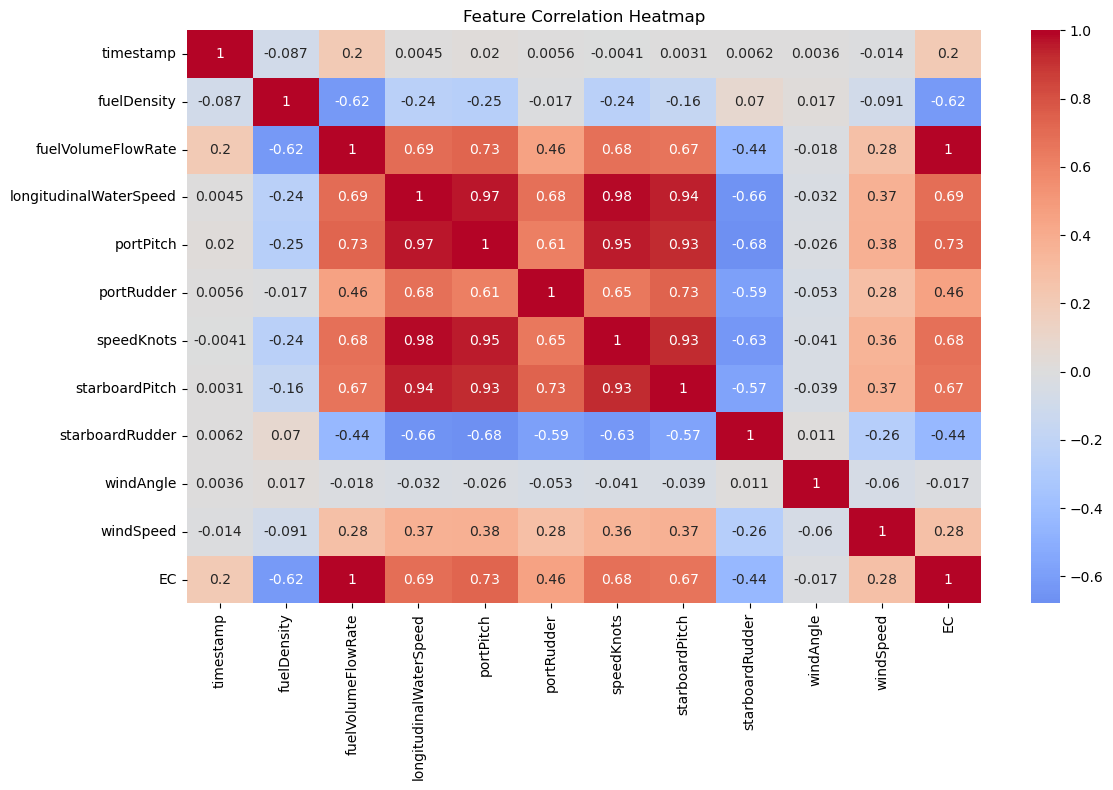

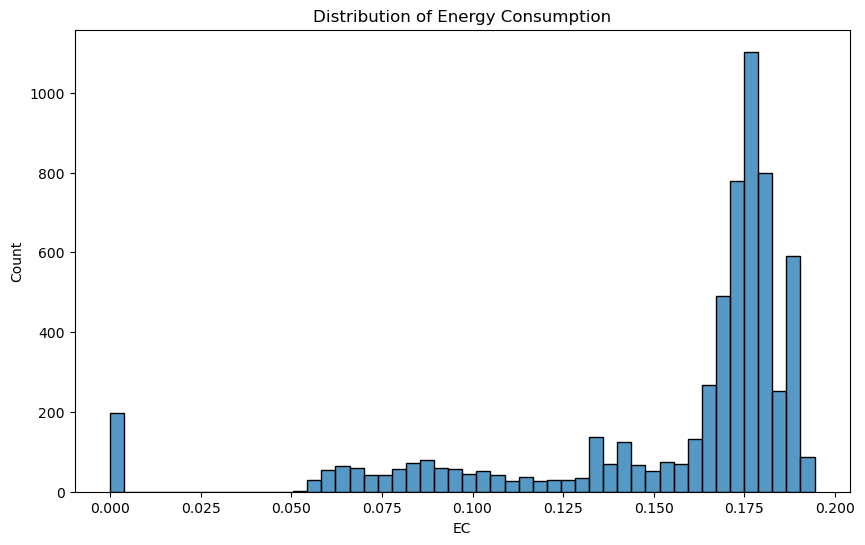

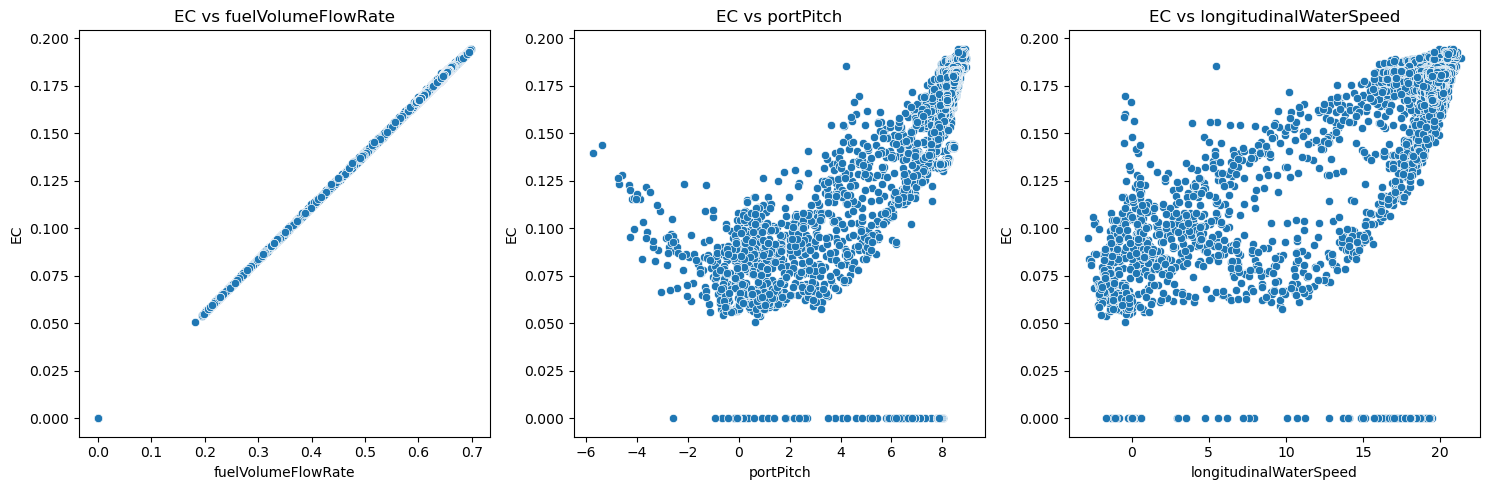

In [130]:
def explore_ml_dataset(df):
    """
    Performs comprehensive exploratory analysis for machine learning preparation.
    """
    print(f"\n{DARK_GREY_BG}Dataset Overview {RESET}")
    print(f"Shape: {df.shape}")
    
    # 1. Missing Values Analysis
    print(f"\n{DARK_GREY_BG}Missing Values Analysis {RESET}")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    }).sort_values('Percentage', ascending=False)
    print(missing_summary)
    
    # 2. Feature Correlations
    print(f"\n{DARK_GREY_BG}Feature Correlations with EC {RESET}")
    correlations = df.corr()['EC'].sort_values(ascending=False)
    print(correlations)
    
    # 3. Basic Statistics
    print(f"\n{DARK_GREY_BG} Basic Statistics {RESET}")
    print(df.describe())
    
    # 4. Create Visualizations
    # Correlation Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Distribution of EC (target variable)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['EC'], bins=50)
    plt.title('Distribution of Energy Consumption')
    plt.xlabel('EC')
    plt.show()
    
    # Scatter plots of top correlated features with EC
    top_corr_features = correlations[1:4].index  # Skip EC itself, take next 3
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, feature in enumerate(top_corr_features):
        sns.scatterplot(data=df, x=feature, y='EC', ax=axes[i])
        axes[i].set_title(f'EC vs {feature}')
    plt.tight_layout()
    plt.show()
    
    return missing_summary, correlations

#############################################################
missing_summary, correlations = explore_ml_dataset(df_prepared)

**Correlations with EC (Target Variable):**
- Very strong positive correlation (0.999) with fuelVolumeFlowRate, which is expected given the EC formula
- Strong positive correlations with: portPitch (0.729), longitudinalWaterSpeed (0.691), speedKnots (0.683), starboardPitch (0.671)
- Moderate negative correlation with fuelDensity (-0.618)
- Weak correlations with wind measurements


**Distribution of EC:**
- Not normally distributed
- Shows a bimodal pattern with: A small peak near zero (likely representing idle/stopped periods), a larger peak around 0.175-0.180 (likely normal operating conditions)
- This distribution might suggest we need separate models for different operating states



**Feature Relationships:**

The scatter plots show:
- Perfect linear relationship between EC and fuelVolumeFlowRate
- Non-linear relationship with portPitch
- Complex relationship with longitudinalWaterSpeed

***Consierations***

> Might consider feature scaling due to different ranges

> Might want to create binary features for operating/non-operating states

> May need to handle the non-linear relationships through feature engineering

Looking at the data it appears quite well suited to be trained. Next we will proceed to build the machine learning model, and we will finetune the dataset later if the results prove to be less than satisfactory.

***
# <span style="color: #f91974  ; font-weight: bold; font-size: 32px;">2.</span> <span style="color: #974efa ; font-size: 32px;"><em>TRAINING </span> 

-  <span style="color: #cddeb3 ;"> Train the models with at least 85% accuracy. </span> 

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">2. a)</span> <span style="color: #b889f9; font-size: 24px;"> Split into Training and Test Dataset </span> 

In [131]:
print(df_prepared.dtypes)

timestamp                 datetime64[s]
fuelDensity                     float64
fuelVolumeFlowRate              float64
longitudinalWaterSpeed          float64
portPitch                       float64
portRudder                      float64
speedKnots                      float64
starboardPitch                  float64
starboardRudder                 float64
windAngle                       float64
windSpeed                       float64
EC                              float64
dtype: object


In [132]:
def split_data_for_model(df):
    """
    Splits the given DataFrame into features (X) and target (y), 
    then further splits into training and test sets.
    """
    # Define features (X) and target (y)
    X = df.drop(columns=['EC', 'fuelDensity', 'fuelVolumeFlowRate', 'timestamp'])
    y = df['EC']
    
    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Print shapes
    print("Training set shape:", X_train.shape)
    print("Training target shape:", y_train.shape)
    print()
    print("Test set shape:", X_test.shape)
    print("Test target shape:", y_test.shape)
    
    return X, y, X_train, X_test, y_train, y_test

#########################################
X, y, X_train, X_test, y_train, y_test = split_data_for_model(df_prepared)

Training set shape: (4985, 8)
Training target shape: (4985,)

Test set shape: (1247, 8)
Test target shape: (1247,)


Setting random_state to a fixed integer ensures that every time the code is run, you get the same random split of the dataset, ensuring reproducibility and allowing to obtain the same results if the code is run multiple times.

**Training Set** 

This is where the model learns patterns and relationships from the features to predict the target variable. 
The training set has 4985 samples with 8 features each, and it is paired with 4985 target values for model training.

**Test Set** 

This is used to evaluate how well the model performs on unseen data (data it hasn't been trained on). It helps assess the model's generalization ability and performance metrics (like accuracy, precision, recall, etc.).
The test set has 1247 samples with the same 8 features, along with 1247 target values to evaluate the model's performance.


## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">2. b)</span> <span style="color: #b889f9; font-size: 24px;"> Train Models </span> 

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Train Model 1: Random Forrest </span>

Random Forest is an ensemble learning method primarily used for classification and regression tasks. A decision tree is a hierarchical model used to make decisions by recursively splitting the data based on feature values, where each internal node represents a condition, and each leaf node represents a predicted outcome. The random forrest model constructs multiple decision trees during training and merges their outputs to improve accuracy and control overfitting. Each tree is trained on a random subset of the training data (with replacement), which helps reduce variance, and at each split in the tree, a random subset of features is considered, promoting diversity among trees and preventing overfitting. It Performs well with large datasets and is less sensitive to noise and outliers compared to individual decision trees. It also provides ascertainable feature importance, helping in understanding which features are influential in predictions.

This approach is particularly well-suited for our ship-energy-consumption task, as it robustly handles a variety of sensor readings (including those with some degree of noise or outliers), captures complex feature interactions, and offers straightforward interpretability via feature importance. Consequently, Random Forest often provides a strong baseline performance on many structured-data problems, making it a natural first choice for our model comparison.

In [133]:
def train_and_predict_rf(X_train, y_train, X_test, random_state=42):
    """ Initializes and trains a Random Forest model, then makes predictions on X_test """
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(random_state=random_state)
    # Train (fit) the model
    rf_model.fit(X_train, y_train)
    # Make predictions
    rf_predictions = rf_model.predict(X_test)
    
    return rf_model, rf_predictions

#######################################
rf_model, rf_predictions = train_and_predict_rf(X_train, y_train, X_test)

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Train Model 2: HistGradientBoostingRegressor </span>

HistGradientBoostingRegressor is a powerful regression model built into scikit-learn that uses gradient boosting to construct an ensemble of decision trees. It operates by sequentially adding trees, where each tree corrects the errors made by the previous ones, making it highly effective for modeling complex, non-linear relationships. This model is particularly efficient because it employs a histogram-based algorithm to bucket continuous features, significantly improving speed and scalability, especially for large datasets. It also includes built-in regularization techniques, such as learning rate adjustment and subsampling, to prevent overfitting.

This model is well-suited for structured data and excels in tasks where both accuracy and efficiency are critical. It handles missing values natively and provides feature importance metrics, aiding interpretability. However, like most boosting models, it may require hyperparameter tuning to achieve optimal performance. In this task, HistGradientBoostingRegressor is ideal for predicting energy consumption as it effectively captures the complex relationships between the features and the target variable, achieving high accuracy with minimal preprocessing.

In [134]:
def train_and_predict_hgb(X_train, y_train, X_test, random_state=42):
    """
    Initializes and trains a HistGradientBoostingRegressor model, then makes predictions on X_test.
    """
    # Initialize the HistGradientBoostingRegressor model
    hist_model = HistGradientBoostingRegressor(random_state=random_state)
    # Train (fit) the model
    hist_model.fit(X_train, y_train)
    # Make predictions
    hist_predictions = hist_model.predict(X_test)
    
    return hist_model, hist_predictions


########################################
hist_model, hist_predictions = train_and_predict_hgb(X_train, y_train, X_test)


***
# <span style="color: #f91974   ; font-weight: bold; font-size: 32px;">3.</span> <span style="color: #974efa   ; font-size: 32px;"><em>EVALUATION</em></span> 

- <span style="color: #cddeb3 ;"> Visualize the performance of your models. </span>

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">3. a)</span> <span style="color: #b889f9; font-size: 24px;"> Evaluate Model Performance </span>

To evaluate the performance of regression models, we use metrics that assess the accuracy of predicted values compared to the actual target values. Unlike classification tasks, where metrics like precision and recall are used, regression tasks focus on continuous outputs and use metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and the R² score to measure performance.

- **Mean Squared Error (MSE):** This metric calculates the average squared difference between the predicted and actual values. Lower values indicate that the model's predictions are closer to the true values. Squaring the errors penalizes larger errors more heavily, making this metric sensitive to outliers.

- **Mean Absolute Error (MAE):** MAE measures the average magnitude of errors in a set of predictions, without considering their direction. It provides a more interpretable measure of average prediction error since it is in the same unit as the target variable. Lower values indicate better performance.

- **R² Score:** The R² score, or the coefficient of determination, measures the proportion of variance in the target variable that is explained by the model. It ranges from 0 to 1, where a value closer to 1 indicates that the model explains most of the variability in the target variable. Negative values indicate that the model performs worse than a simple mean prediction.

By evaluating models using these metrics, we can determine how well they generalize to unseen data. In this task, we use these metrics to compare the Random Forest and HistGradientBoostingRegressor models, allowing us to identify which model provides better predictions of energy consumption.

In [135]:
def evaluate_regression_model(model_name, y_test, y_predictions):
    """ Evaluates a regression model using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score. """
    
    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_predictions)
    mae = mean_absolute_error(y_test, y_predictions)
    r2 = r2_score(y_test, y_predictions)
    
    # Print results
    print(f"\n{GREY_BG}{model_name} Model Evaluation:{RESET}")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.6f}")

    # Return as a dictionary for potential further use
    return {"MSE": mse, "MAE": mae, "R2": r2}


#################################################################
rf_metrics = evaluate_regression_model("Random Forest", y_test, rf_predictions)
hist_metrics = evaluate_regression_model("HistGradientBoosting", y_test, hist_predictions)


Random Forest Model Evaluation:
Mean Squared Error (MSE): 0.000237
Mean Absolute Error (MAE): 0.004905
R² Score: 0.885517

HistGradientBoosting Model Evaluation:
Mean Squared Error (MSE): 0.000191
Mean Absolute Error (MAE): 0.005320
R² Score: 0.907813


The Random Forest model and the HistGradientBoostingRegressor demonstrate varying strengths in predicting energy consumption, with the latter performing significantly better in terms of accuracy and error metrics.

The Random Forest model achieves an R2 score of 0.885, indicating that it explains 88.5% of the variance in the target variable. Its Mean Squared Error (MSE) and Mean Absolute Error (MAE) values suggest that while it performs well, there is room for improvement in capturing the finer details of the data.

On the other hand, the HistGradientBoostingRegressor achieves an impressive R2 score of appox 0.91, meaning it explains 91% of the variance in the target variable. This makes it a slightly better fit for the data. Additionally, its MSE and MAE are lower than those of the Random Forest model, indicating more precise predictions and fewer outliers affecting the model's performance.

Random Forest:
- MSE: Higher than HistGradientBoosting, showing more deviation from the actual values.
- MAE: Indicates moderate prediction errors across the dataset.
- R²: Good at capturing relationships but less robust compared to HistGradientBoosting.

HistGradientBoosting:
- MSE: Llower, suggesting the model's predictions are closer to actual values.
- MAE: Indicates smaller average prediction errors, demonstrating superior accuracy.
- R²: Highlights that the model captures nearly all the variability in the target variable, making it the better model overall.

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">3. b)</span> <span style="color: #b889f9; font-size: 24px;"> Visualize Performance </span>

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Scatter Plot </span>

The scatter points represent how well the model's predictions align with the actual values. Ideally, all points should lie close to the red dashed line for perfect predictions.


In [136]:
def plot_actual_vs_predicted(y_actual, y_predicted, model_name="Model"):
    """ Plots Actual vs. Predicted values for a regression model """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.7, label="Predicted vs Actual")
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 
             'r--', label="Perfect Prediction", linewidth=2)
    plt.title(f"Actual vs Predicted Values ({model_name})")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.show()

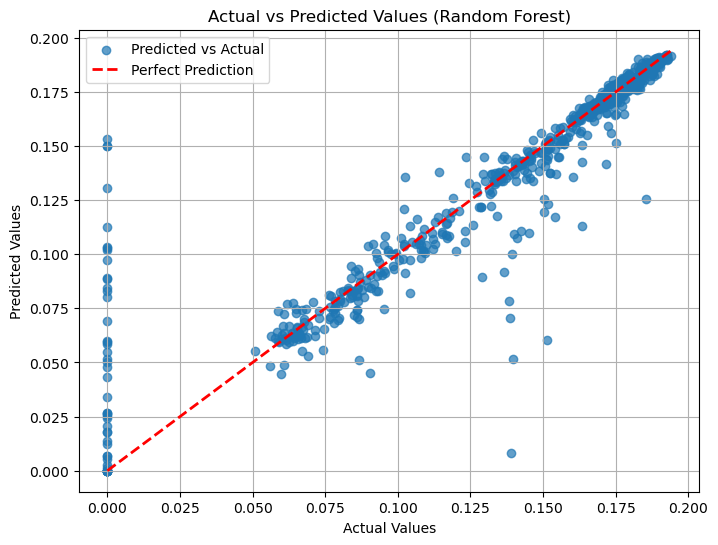

In [137]:
plot_actual_vs_predicted(y_test, rf_predictions, model_name="Random Forest")

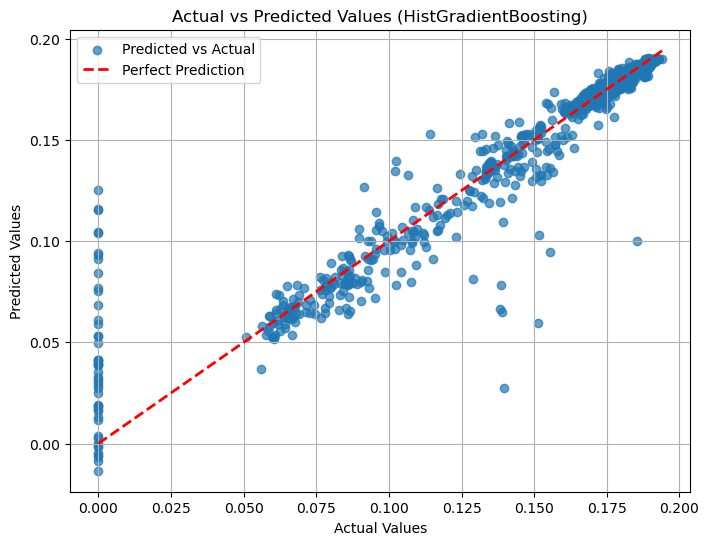

In [138]:
plot_actual_vs_predicted(y_test, hist_predictions, model_name="HistGradientBoosting")

In both plots, most points are concentrated around the red line, indicating good prediction accuracy.

Random Forest: The first plot shows predictions from the Random Forest model. While the predictions are generally close to the red line, some scatter is visible, especially at lower values.

HistGradientBoosting: The second plot displays predictions from the HistGradientBoosting model. It appears to show a similar level of performance, with the points clustering closer to the red line.

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Error Distribution Charts </span>

These error distribution charts show the residuals (differences between actual and predicted values) for the Random Forest and HistGradientBoosting models. 

In [139]:
def plot_error_distribution(y_actual, y_predicted, model_name="Model"):
    """ Plots the distribution of residuals (errors) for a regression model. """
    
    residuals = y_actual - y_predicted
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, color="blue", label="Residuals")
    plt.axvline(x=0, color='r', linestyle='--', label="Zero Error Line")
    plt.title(f"Error Distribution ({model_name})")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

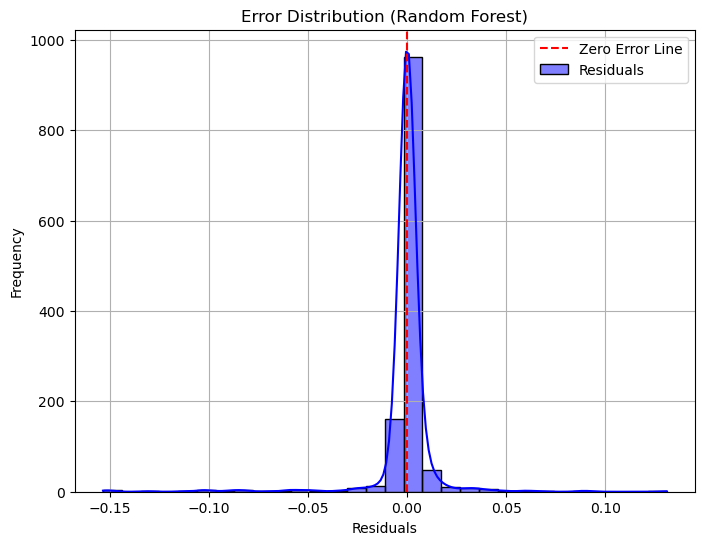

In [140]:
plot_error_distribution(y_test, rf_predictions, model_name="Random Forest")

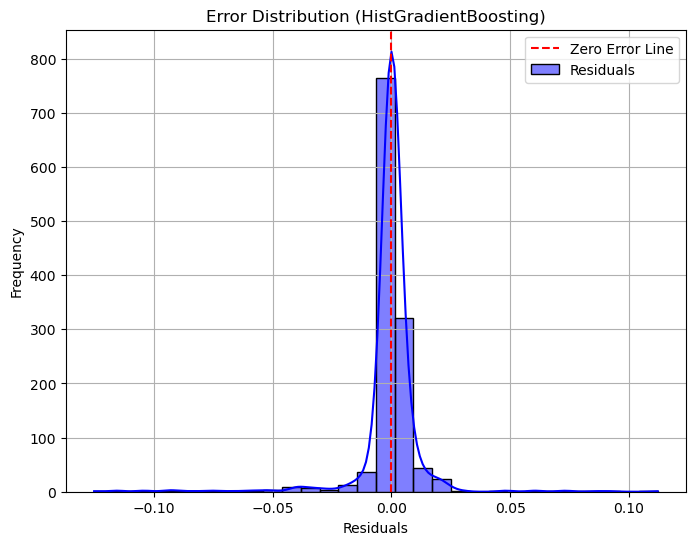

In [141]:
plot_error_distribution(y_test, hist_predictions, model_name="HistGradientBoosting")

Both distributions are centered around zero, indicating that neither model has significant bias (i.e., they don't consistently over- or under-predict). However, HistGradientBoosting exhibits a narrower spread and sharper peak around zero, meaning it makes smaller and more consistent errors compared to Random Forest, which has a wider spread and longer tails, suggesting larger occasional errors. This aligns with the better Mean Squared Error (MSE) and Mean Absolute Error (MAE) scores for HistGradientBoosting, making it the more precise model.

***
# <span style="color: #f91974  ; font-weight: bold; font-size: 32px;">4.</span> <span style="color: #974efa  ; font-size: 32px;"><em>COMPARISON</em></span> 

- <span style="color: #cddeb3   ;">Compare the results of different models, why is there a difference? </span>

In this final section, we draw a comparative analysis of the models performance, first however we examine how individual features contribute to each model’s performance. We do this for both the Random Forest and HistGradientBoostingRegressor, allowing us to compare how different features influence each model’s predictions.

## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">4. a)</span> <span style="color: #b889f9; font-size: 24px;"> Comparison Metrics </span>

In [142]:
def plot_feature_importance(model, feature_names, model_name="Model"):
    """ Plots feature importance for tree-based models. """
    
    if not hasattr(model, "feature_importances_"):
        raise ValueError(f"The model {model_name} does not support feature importance.")
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
    plt.title(f"Feature Importance ({model_name})")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.grid(True)
    plt.show()

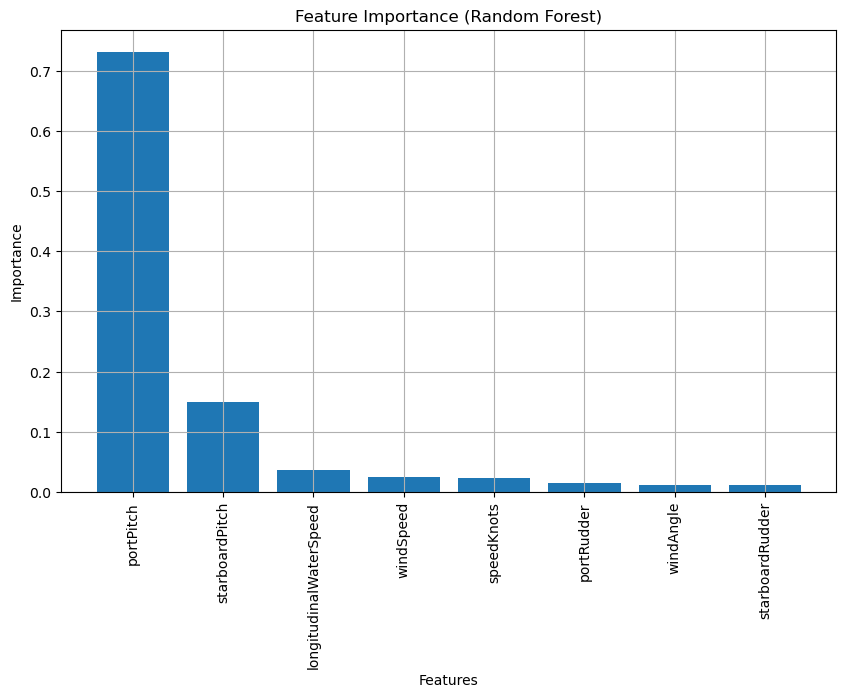

In [143]:
feature_names = X.columns.tolist()

# Plot for Random Forest
plot_feature_importance(rf_model, feature_names, model_name="Random Forest")

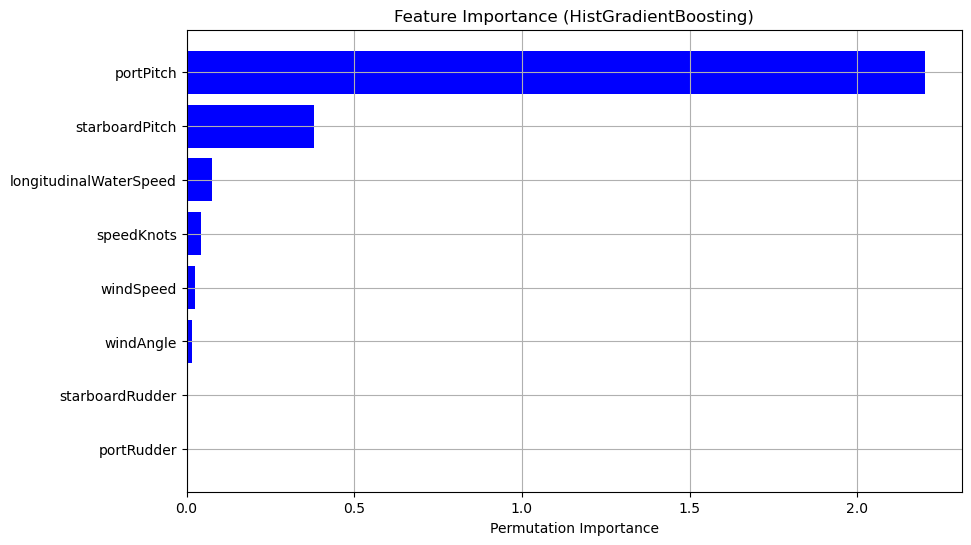

In [144]:

def plot_permutation_importance(model, X_test, y_test, feature_names, model_name="Model", n_repeats=10, random_state=42):
    """ Computes and plots permutation importance for a regression model. """
    # Compute permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=random_state)

    # Extract and sort feature importances
    sorted_idx = perm_importance.importances_mean.argsort()

    # Plot permutation importance
    plt.figure(figsize=(10, 6))
    plt.barh([feature_names[i] for i in sorted_idx], perm_importance.importances_mean[sorted_idx], color="blue")
    plt.xlabel("Permutation Importance")
    plt.title(f"Feature Importance ({model_name})")
    plt.grid(True)
    plt.show()

    # Return importance scores as a dictionary
    return {feature_names[i]: perm_importance.importances_mean[i] for i in sorted_idx}

################################################################
hist_importance = plot_permutation_importance(hist_model, X_test, y_test, feature_names, model_name="HistGradientBoosting")

>Both models agree on the dominance of portPitch and starboardPitch, which strongly influence energy consumption. This is expected since propulsion parameters are key factors in ship energy systems.

>HistGradientBoosting provides slightly more nuanced importance across features due to its algorithmic structure, but the overall patterns are consistent with Random Forest.

***High Importance***

- **portPitch** refers to the pitch of the port-side propeller, which controls how much thrust the propeller produces. Adjusting the propeller pitch directly affects fuel consumption because it determines the engine load and propulsion efficiency. Energy consumption on a ship is heavily influenced by propulsion parameters. Propeller pitch is a primary driver of how much fuel the engines consume because it governs the power delivered to move the ship through water. For example:
Higher pitch increases propulsion but demands more fuel.
Lower pitch may reduce fuel consumption but could be less efficient for maintaining speed.
Operational Conditions:

- **starboardPitch**. Similar to portPitch, the starboardPitch governs the thrust generated by the starboard-side propeller. The importance of both propeller pitches indicates that the energy model depends on balanced propulsion across the ship's two propellers.

***Moderate Importance***

- **longitudinalWaterSpeed** measures the speed of the ship through the water, which affects fuel consumption. Higher speeds typically demand more energy, although efficiency can vary with the engine load and hydrodynamic factors.

- **speedKnots**. These are measures of speed over the ground (SOG), which might be less directly tied to energy consumption than water speed (longitudinalWaterSpeed) because water resistance has a more direct impact on propulsion efficiency.

***Low Importance***

- **Wind conditions** can affect ship resistance and energy consumption. However, the model assigns lower importance, likely because the effects of wind are indirectly captured through the adjustments in portPitch and starboardPitch.


- **Rudder Angles** (portRudder and starboardRudder): Rudder positions primarily affect maneuvering rather than propulsion efficiency during steady-state operation, hence their lower importance.


## <span style="color: #f91974  ; font-weight: bold; font-size: 18px;">4. b)</span> <span style="color: #b889f9; font-size: 24px;"> Comparison Analysis </span>

1. Capturing Nonlinear Interactions
- HistGradientBoosting is inherently designed to capture complex nonlinear relationships between features and the target variable through its sequential learning process.
- Features like portPitch, starboardPitch, and longitudinalWaterSpeed likely interact in nonlinear ways to influence energy consumption. For instance:
The impact of portPitch might depend on longitudinalWaterSpeed.
- Wind factors (windAngle, windSpeed) may have multiplicative or nonlinear effects with propeller pitch or rudder angles.
- Random Forest, while powerful, averages results across independent trees and may struggle to fully capture these subtle relationships, especially in datasets with interdependent features.
2. Handling Sparse and Zero Data
- The dataset shows instances where energy consumption (EC) is zero (e.g., during idle states or when the ship is stationary). Gradient boosting models like HistGradientBoosting are better at distinguishing between these "easy-to-predict" cases (e.g., zero consumption) and more complex ones (e.g., under varying conditions), leading to better performance on both types of data.
3. Feature Importance Usage
- HistGradientBoosting assigns slightly more nuanced weights to lower-ranked features like windSpeed, windAngle, and rudder angles. These features might contribute small but consistent improvements to the prediction accuracy, especially in edge cases where propulsion features alone cannot explain variations in energy consumption.
- Random Forest, on the other hand, relies more heavily on portPitch and starboardPitch, which could make it less robust in scenarios where other factors play a significant role.
4. Sensitivity to Outliers
- Gradient Boosting is typically more robust to outliers in the target variable (EC) because it minimizes the loss function iteratively, focusing more on "difficult-to-predict" instances. This property might give HistGradientBoosting an edge when there are occasional anomalies in fuel consumption due to sudden changes in ship conditions or sensor noise.


>HistGradientBoosting outperforms Random Forest in this case because:
>- It captures nonlinear feature interactions better.
>- It handles sparse data and edge cases (e.g., zero energy consumption) more effectively.
>- It utilizes lower-ranked features like wind-related variables to improve prediction consistency.
>- It is more robust to outliers, leading to better overall accuracy and lower residual errors.

***
# <span style="color: #f91974  ; font-weight: bold; font-size: 32px;">5.</span> <span style="color: #974efa  ; font-size: 32px;"><em>.NET TIMESTAMPS</em></span> 

This section replicates our entire machine learning pipeline, but using the **.NET timestamp-corrected dataset** instead of our original **normalized timestamp dataset**.  

**Why This Section?**  
In our initial approach, timestamps were **normalized** and mapped to fit a fixed time range (2010-02-01 to 2010-04-01). However, our teacher clarified that the dataset **contained timestamps stored in .NET ticks (100-nanosecond intervals)**, which needed to be **converted to Unix time** rather than rescaled.  

**What This Section Does**  
- Loads the raw data and **correctly converts .NET ticks to Unix timestamps**, ensuring alignment with real-world time.  
- **Rounds timestamps to seconds** instead of keeping them in 100-nanosecond intervals.  
- Runs **the exact same preprocessing pipeline** (column selection, gap removal, resampling, and filling).  
- Trains **the same two machine learning models** (Random Forest & HistGradientBoosting).  
- Evaluates the models on the **corrected dataset**.  
- Compares **feature importance and error distributions** between the two versions.  

This ensures that our results are **robust** and aligned with **real-world timestamps**, allowing us to compare the impact of **time normalization vs. proper timestamp conversion** on model performance.



<span style="color:rgb(137, 187, 249); font-size: 20px;"> Perform .NET based training </span> 

In [145]:
# Merge raw data again
df_NetTimestamps = merge_dataframes(dfs_dict)                 #  <------------ df_NetTimestamps

# Drop columns
df_NetTimestamps = drop_columns(df_NetTimestamps)

Combined DataFrame Info 
<class 'pandas.core.frame.DataFrame'>
Index: 19045464 entries, 634018095128184147 to 634067079164694510
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   fuelDensity             float64
 1   fuelTemp                float64
 2   fuelVolumeFlowRate      float64
 3   inclinometer-raw        float64
 4   latitude                object 
 5   longitude               object 
 6   level1median            float64
 7   level2median            float64
 8   longitudinalWaterSpeed  float64
 9   portPitch               float64
 10  portRudder              float64
 11  speedKmh                float64
 12  speedKnots              float64
 13  starboardPitch          float64
 14  starboardRudder         float64
 15  trackDegreeMagnetic     float64
 16  trackDegreeTrue         float64
 17  trueHeading             float64
 18  windAngle               float64
 19  windSpeed               float64
dtypes: float64(18), obj

In [ ]:
# .NET ticks 
dotnet_ticks = df_NetTimestamps.index  

# 1) Subtract the .NET epoch offset (in ticks)
NET_EPOCH_OFFSET = 621355968000000000
unix_ticks = dotnet_ticks - NET_EPOCH_OFFSET

# 2) Convert to microseconds by dividing by 10
#    (since each tick is 100 ns = 0.1 µs)
unix_micros = unix_ticks / 10

# 3) Convert to Pandas Timestamps, coerce invalid values to NaT
df_NetTimestamps.index = pd.to_datetime(unix_micros, unit='us', errors='coerce')

# df.index holds Pandas timestamps aligned to the Unix epoch

In [147]:
# Display missing rates
display_missing_rates(df_NetTimestamps, "Missing Rates Before Gap Removal/Resampling (DataFrame: ddf_NetTimestamp)")

# Print min and max timestamps from the index
print("Min timestamp:", df_NetTimestamps.index.min())
print("Max timestamp:", df_NetTimestamps.index.max())

# Inspect a few rows
print(df_NetTimestamps.head(20))


Missing Rates Before Gap Removal/Resampling (DataFrame: ddf_NetTimestamp) 
Dataset shape: (6532355, 10)

Missing rates by column:
longitudinalWaterSpeed     91.61%
windAngle                  86.78%
windSpeed                  86.78%
fuelDensity                75.09%
fuelVolumeFlowRate         75.09%
portPitch                  73.58%
portRudder                 73.58%
starboardPitch             73.58%
starboardRudder            73.58%
speedKnots                 72.95%
Min timestamp: 2010-02-15 05:45:13.069313
Max timestamp: 2010-04-12 22:25:16.469451
                            fuelDensity  fuelVolumeFlowRate  longitudinalWaterSpeed  portPitch  portRudder  speedKnots  starboardPitch  starboardRudder  windAngle  windSpeed
2010-02-15 05:45:13.069313          NaN                 NaN                     NaN        NaN         NaN         0.6             NaN              NaN        NaN        NaN
2010-02-15 05:45:13.558250          NaN                 NaN                     NaN      2.127   


Energy Consumption Statistics 

Shape: (6532355, 12)

EC Summary Statistics:
count    1.627324e+06
mean     1.636461e-01
std      3.310100e-02
min      0.000000e+00
25%      1.632960e-01
50%      1.740278e-01
75%      1.816112e-01
max      2.641985e-01
Name: EC, dtype: float64

Missing values in EC: 4905031

Dataset Overview 
Shape: (6532355, 12)

Missing Values Analysis 
                        Missing Values  Percentage
longitudinalWaterSpeed         5984063   91.606519
windAngle                      5668600   86.777280
windSpeed                      5668600   86.777280
fuelDensity                    4905031   75.088249
fuelVolumeFlowRate             4905031   75.088249
EC                             4905031   75.088249
portPitch                      4806279   73.576513
portRudder                     4806279   73.576513
starboardPitch                 4806279   73.576513
starboardRudder                4806279   73.576513
speedKnots                     4765447   72.951439
timestamp   

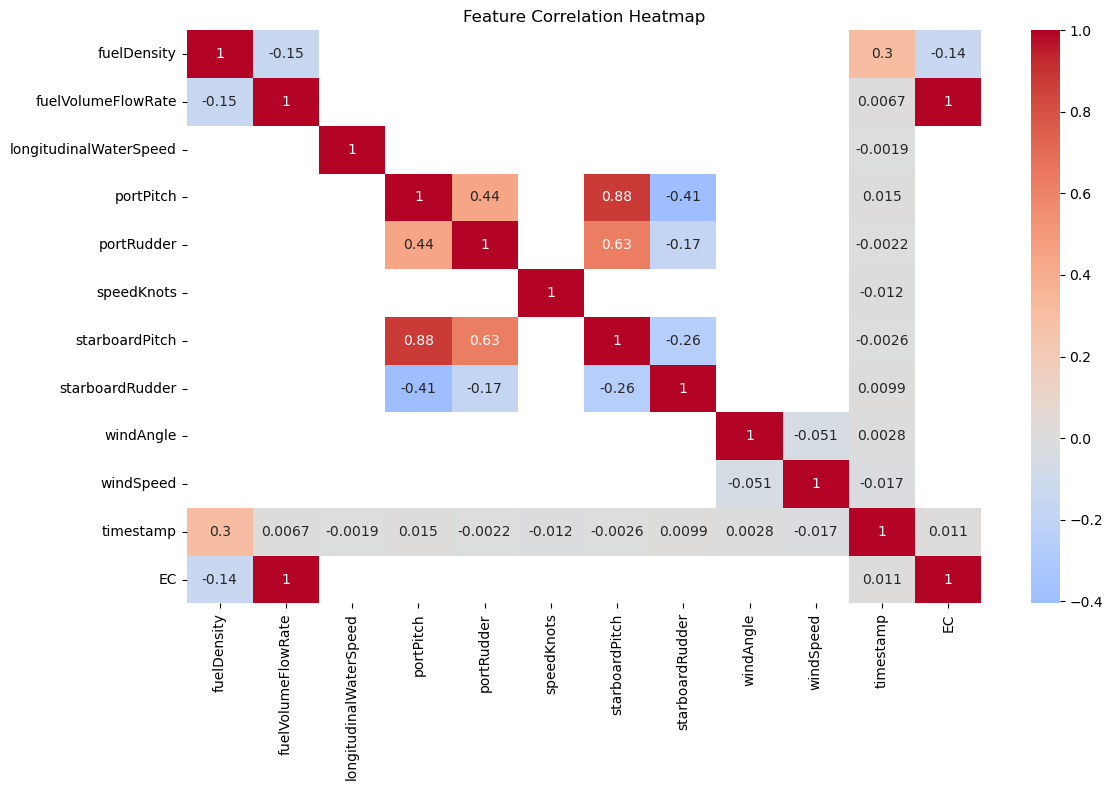

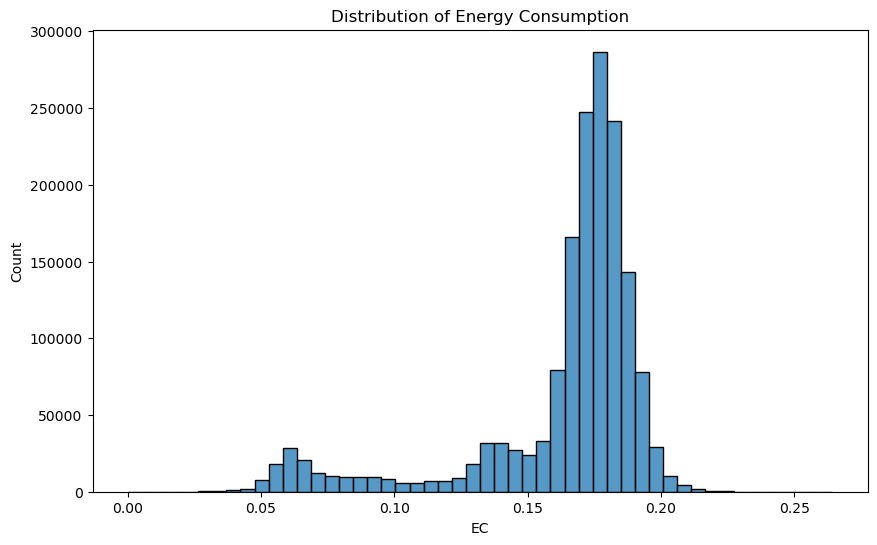

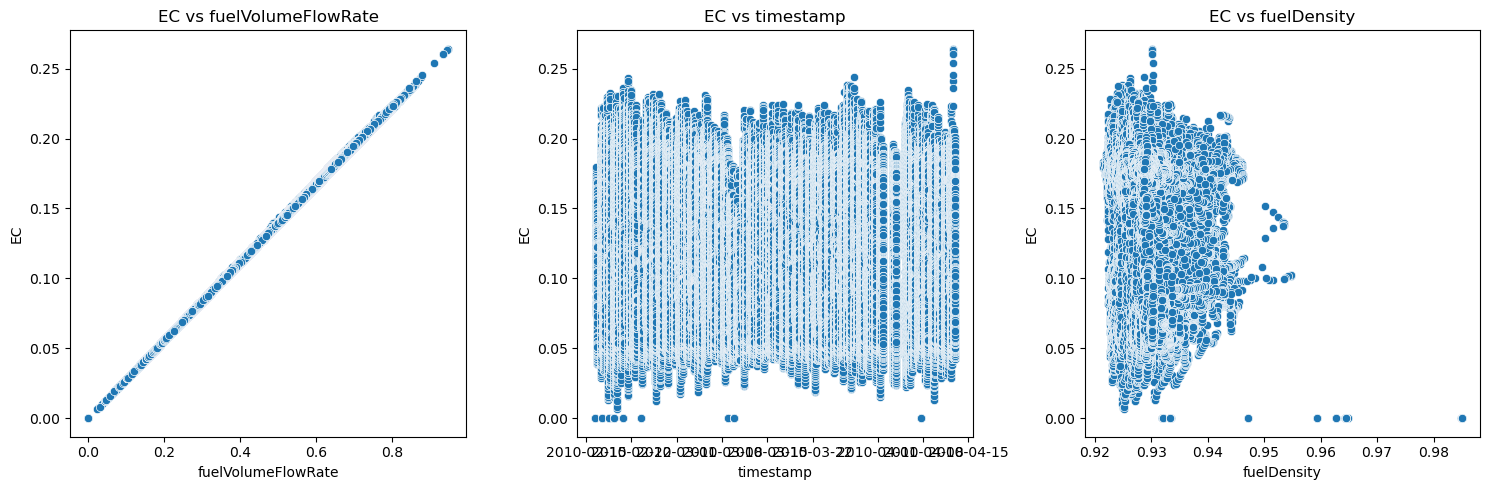

(                        Missing Values  Percentage
 longitudinalWaterSpeed         5984063   91.606519
 windAngle                      5668600   86.777280
 windSpeed                      5668600   86.777280
 fuelDensity                    4905031   75.088249
 fuelVolumeFlowRate             4905031   75.088249
 EC                             4905031   75.088249
 portPitch                      4806279   73.576513
 portRudder                     4806279   73.576513
 starboardPitch                 4806279   73.576513
 starboardRudder                4806279   73.576513
 speedKnots                     4765447   72.951439
 timestamp                            0    0.000000,
 EC                        1.000000
 fuelVolumeFlowRate        0.999917
 timestamp                 0.010747
 fuelDensity              -0.136679
 longitudinalWaterSpeed         NaN
 portPitch                      NaN
 portRudder                     NaN
 speedKnots                     NaN
 starboardPitch                 NaN

In [148]:
df_NetTimestamps['timestamp'] = df_NetTimestamps.index
df_NetTimestamps = calculate_energy_consumption(df_NetTimestamps)

explore_ml_dataset(df_NetTimestamps)

In [ ]:
# Remove big gaps, resample, etc. (same as original steps)
df_NetTimestamps = drop_gap_missing_rows(df_NetTimestamps)
df_NetTimestamps = df_NetTimestamps.resample('5T').mean()  
df_NetTimestamps.dropna(subset=['fuelDensity','fuelVolumeFlowRate'], how='all', inplace=True)
df_NetTimestamps = df_NetTimestamps.ffill().bfill()

Dropping 3 rows between 2010-02-16 15:15:19.389464 and 2010-02-17 06:44:07.155207 (gap 15.48 hours)
Dropping 32079 rows between 2010-02-22 21:19:29.608733 and 2010-02-23 11:24:04.267021 (gap 14.08 hours)
Dropping 5 rows between 2010-03-31 20:03:58.073255 and 2010-04-01 08:11:48.174319 (gap 12.13 hours)
Dropping 3 rows between 2010-04-01 21:45:05.641579 and 2010-04-03 08:26:21.932535 (gap 34.69 hours)
Dropping 3 rows between 2010-04-03 21:32:06.895010 and 2010-04-05 05:41:32.279072 (gap 32.16 hours)



Missing Rates After Gap Removal/Resampling (DataFrame: ddf_NetTimestamp) 
Dataset shape: (5809, 12)

Missing rates by column:
fuelDensity                 0.00%
fuelVolumeFlowRate          0.00%
longitudinalWaterSpeed      0.00%
portPitch                   0.00%
portRudder                  0.00%
speedKnots                  0.00%
starboardPitch              0.00%
starboardRudder             0.00%
windAngle                   0.00%
windSpeed                   0.00%
timestamp                   0.00%
EC                          0.00%
Min timestamp: 2010-02-16 10:50:13.345875712
Max timestamp: 2010-04-12 22:25:08.261098752

Dataset Overview 
Shape: (5809, 12)

Missing Values Analysis 
                        Missing Values  Percentage
fuelDensity                          0         0.0
fuelVolumeFlowRate                   0         0.0
longitudinalWaterSpeed               0         0.0
portPitch                            0         0.0
portRudder                           0         0.0
speedK

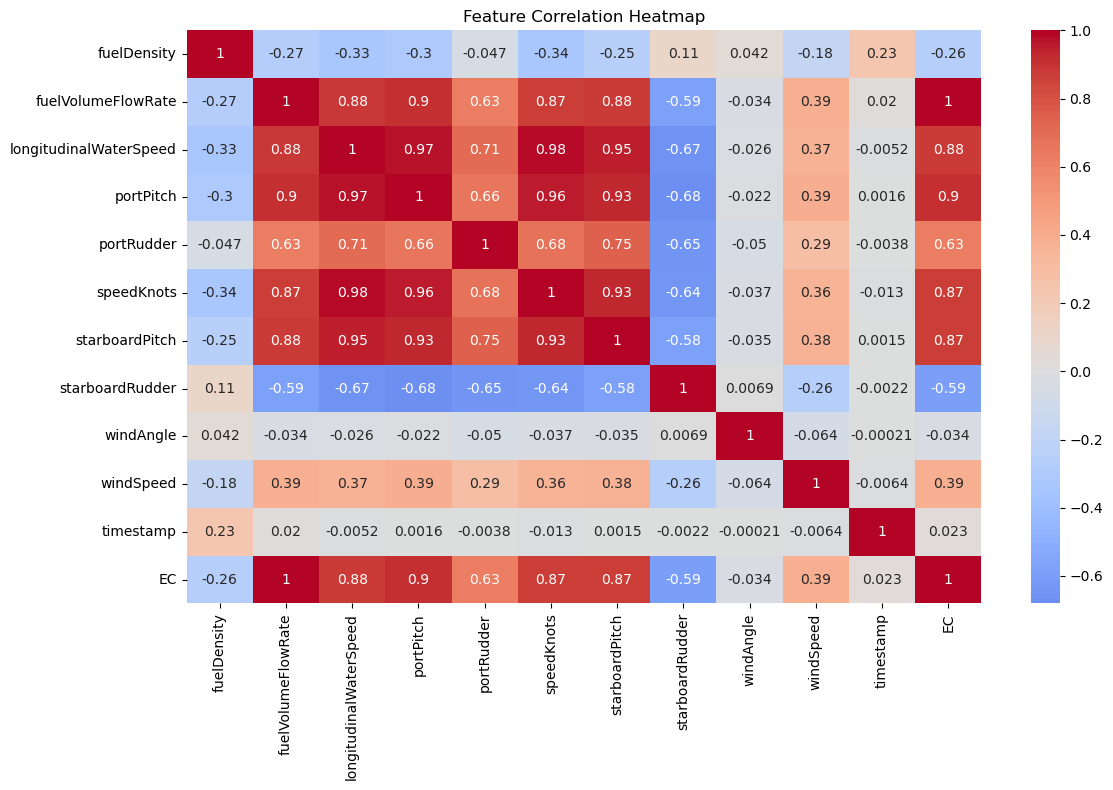

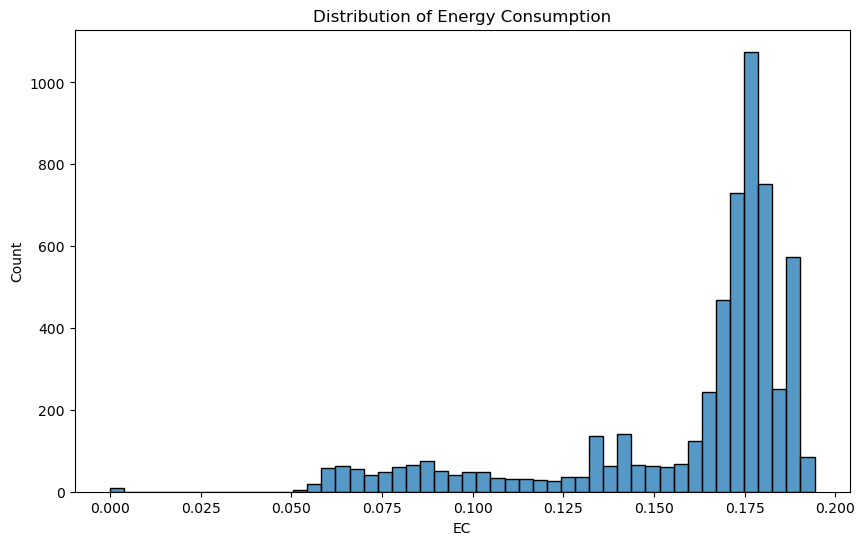

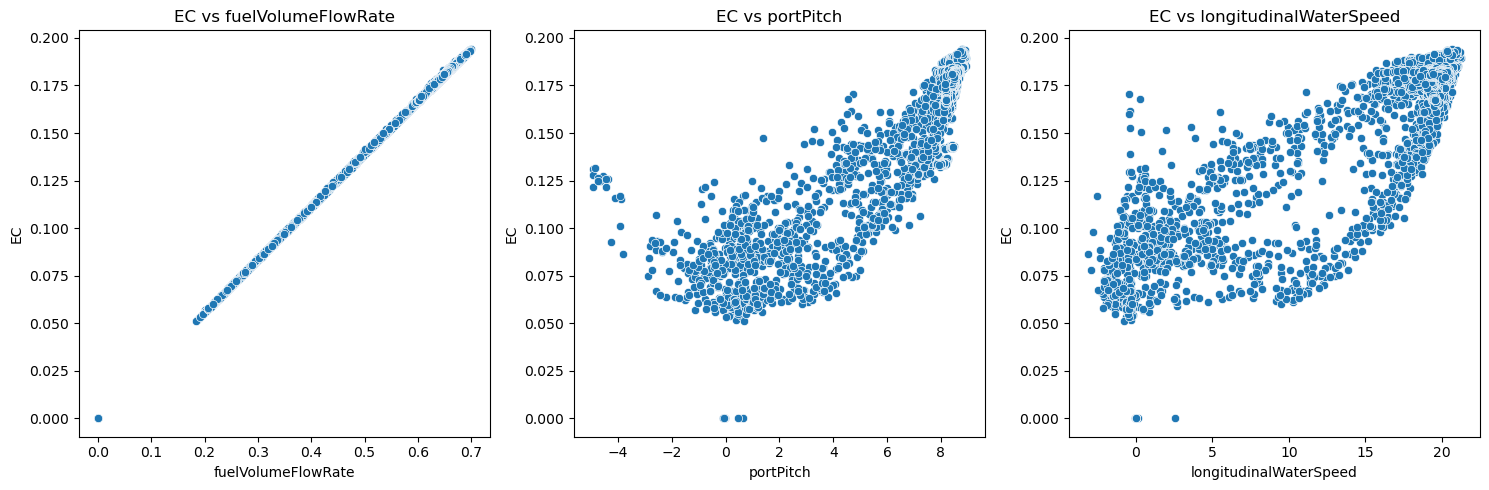

(                        Missing Values  Percentage
 fuelDensity                          0         0.0
 fuelVolumeFlowRate                   0         0.0
 longitudinalWaterSpeed               0         0.0
 portPitch                            0         0.0
 portRudder                           0         0.0
 speedKnots                           0         0.0
 starboardPitch                       0         0.0
 starboardRudder                      0         0.0
 windAngle                            0         0.0
 windSpeed                            0         0.0
 timestamp                            0         0.0
 EC                                   0         0.0,
 EC                        1.000000
 fuelVolumeFlowRate        0.999926
 portPitch                 0.902471
 longitudinalWaterSpeed    0.880605
 starboardPitch            0.874977
 speedKnots                0.872756
 portRudder                0.628386
 windSpeed                 0.386775
 timestamp                 0.023482

In [150]:
# Print information on DataFrame
display_missing_rates(df_NetTimestamps, "Missing Rates After Gap Removal/Resampling (DataFrame: ddf_NetTimestamp)")
print("Min timestamp:", df_NetTimestamps['timestamp'].min())
print("Max timestamp:", df_NetTimestamps['timestamp'].max())
df_NetTimestamps.head(20)
explore_ml_dataset(df_NetTimestamps)

# Then train/test split, train models, evaluate, etc.

In [151]:
X, y, X_train, X_test, y_train, y_test = split_data_for_model(df_NetTimestamps)

Training set shape: (4647, 8)
Training target shape: (4647,)

Test set shape: (1162, 8)
Test target shape: (1162,)


In [ ]:
X_train.columns

Index(['longitudinalWaterSpeed', 'portPitch', 'portRudder', 'speedKnots', 'starboardPitch', 'starboardRudder', 'windAngle', 'windSpeed'], dtype='object')

In [62]:
rf_model, rf_predictions = train_and_predict_rf(X_train, y_train, X_test)
hist_model, hist_predictions = train_and_predict_hgb(X_train, y_train, X_test)

In [63]:
rf_metrics = evaluate_regression_model("Random Forest", y_test, rf_predictions)
hist_metrics = evaluate_regression_model("HistGradientBoosting", y_test, hist_predictions)


Random Forest Model Evaluation:
Mean Squared Error (MSE): 0.000016
Mean Absolute Error (MAE): 0.002168
R² Score: 0.985044

HistGradientBoosting Model Evaluation:
Mean Squared Error (MSE): 0.000021
Mean Absolute Error (MAE): 0.002458
R² Score: 0.981035


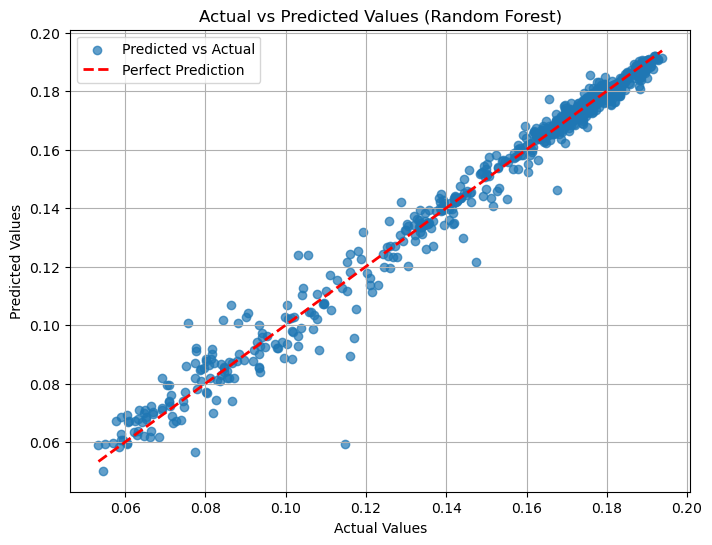

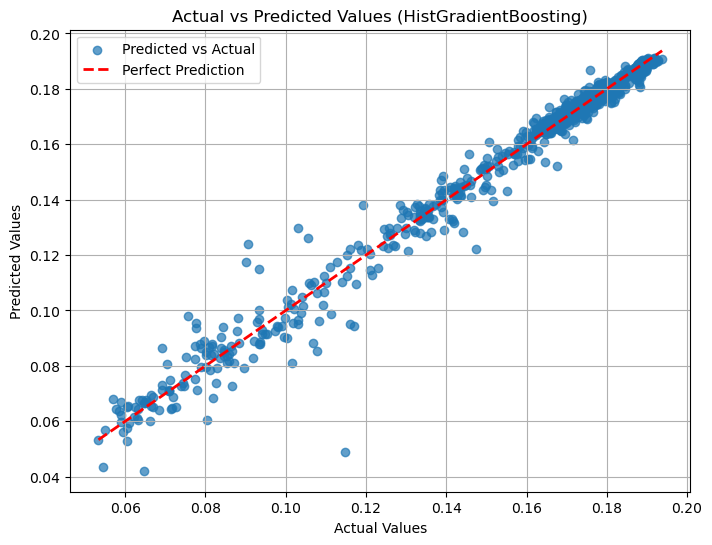

In [64]:
plot_actual_vs_predicted(y_test, rf_predictions, model_name="Random Forest")
plot_actual_vs_predicted(y_test, hist_predictions, model_name="HistGradientBoosting")

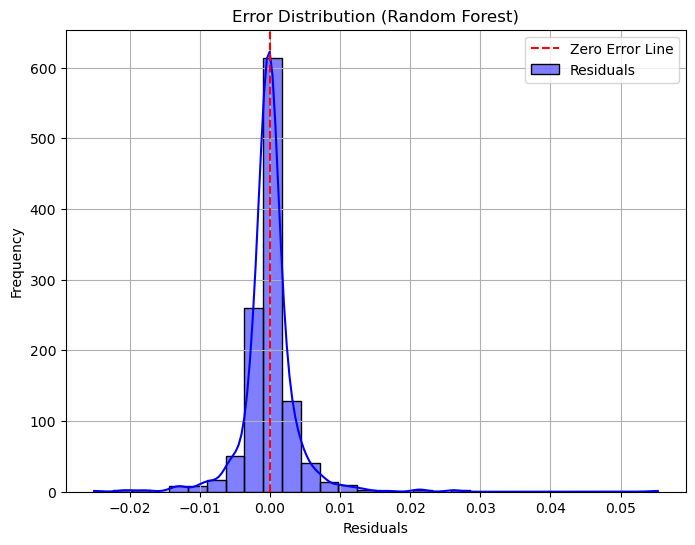

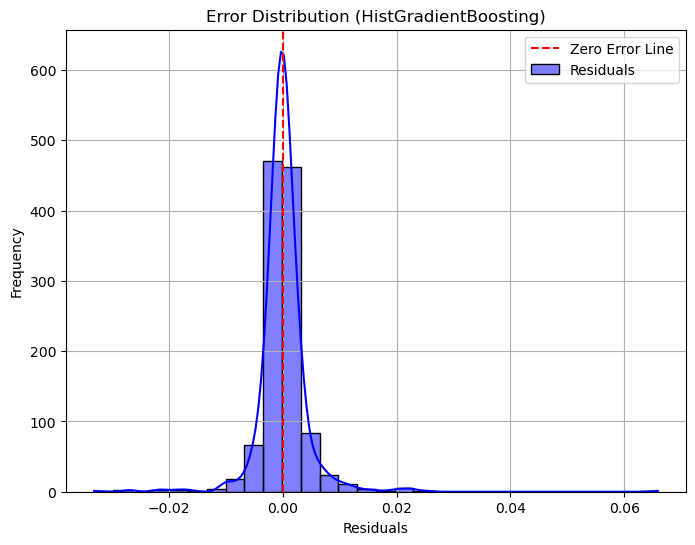

In [65]:
plot_error_distribution(y_test, rf_predictions, model_name="Random Forest")
plot_error_distribution(y_test, hist_predictions, model_name="HistGradientBoosting")

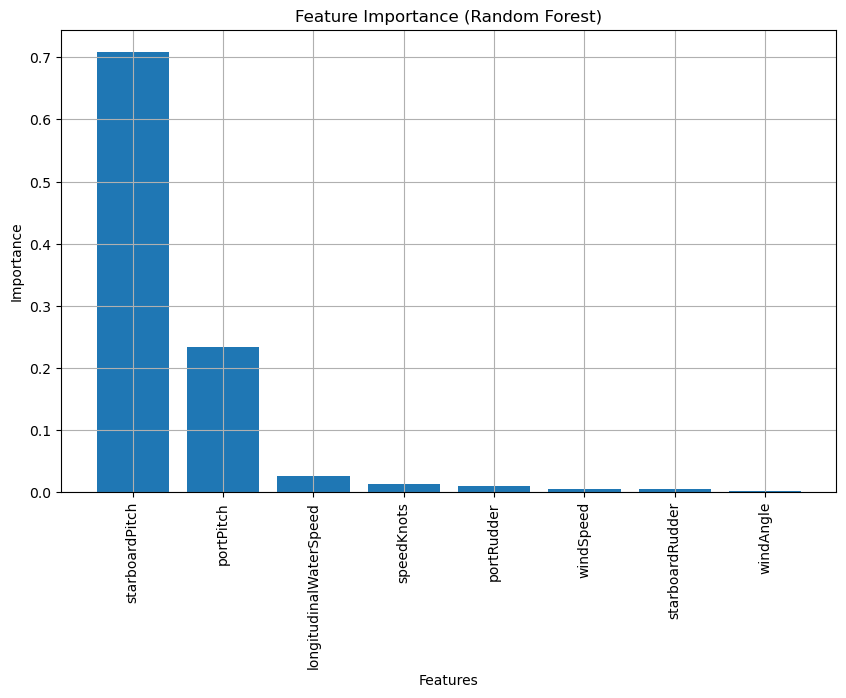

In [66]:
feature_names = X.columns.tolist()

plot_feature_importance(rf_model, feature_names, model_name="Random Forest")

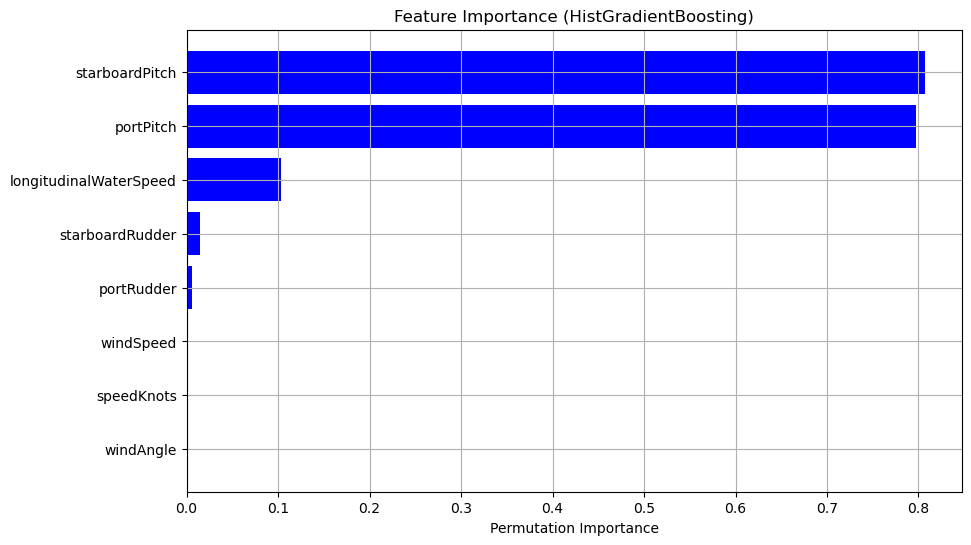

In [67]:
hist_importance = plot_permutation_importance(hist_model, X_test, y_test, feature_names, model_name="HistGradientBoosting")

<span style="color:rgb(137, 187, 249); font-size: 20px;"> Analysis of the New Results </span> 

Below is a concise interpretation of/why how the model evaluations may differ once we properly convert .NET ticks rather than using normalized timestamps, and also an analysis of how the results actually differed.

**More Accurate Time Alignment Impact**

- With the .NET approach, each record’s timestamp now reflects the true (real-world) moment it was collected.
- In contrast, the normalized approach artificially mapped all data into a fixed date range (e.g., February 1 to April 1), which can shuffle or compress intervals.
- This improved alignment can change how sensor readings pair up in each time bin, slightly altering both the training distribution and the relationships between features.
- When timestamps are handled correctly, the frequency and spacing of measurements are more faithful to actual ship operations. This can reduce or change certain gaps and outliers. For instance, idle periods (EC near zero) might appear at different places in the timeline, affecting how models learn about low-consumption vs. normal-operation states.

**Notional Impact on Model Performance**

- HistGradientBoosting may see marginally improved consistency (e.g., tighter error distributions), because time-series continuity is better respected.
- Random Forest can also benefit or shift in performance if the real distribution leads to slightly different training subsets. Any improvement (or difference) in R², MAE, or MSE stems from the fact that the underlying training data is now more representative of true operational sequences.

**Actual Difference in Performance**

- Higher Overall Accuracy for Both Models: By using actual time intervals rather than an artificial normalization, the sensor readings and fuel-consumption values are better aligned. This alignment reduces “noise” introduced by mismatched timestamps, so both Random Forest and HistGradientBoosting can learn more faithfully from the true operational patterns. As a result, you see lower errors (MSE, MAE) and higher R² for both models compared to the normalized-timestamp scenario.

- Narrower Performance Gap: Under the normalized approach, there may have been quirks in how data was aggregated or how gaps were distributed, possibly favoring one model over the other. Random Forest benefits from clearer, more consistent splits, while HistGradientBoosting still handles nonlinearities well; the end result is both models improve, and their performance metrics end up more similar.

In short, proper time alignment (via .NET ticks) removes artificial distortions in the dataset, boosting the accuracy of both algorithms and making their performance more comparable.